# Logistic Regression Model

## Data Import And Cleaning

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import scripts.logistic_regression_functions as lrf
import scripts.helper_functions as hf
from sklearn.preprocessing import StandardScaler

#reloads the module with the most recent updates
%load_ext autoreload
%aimport scripts.logistic_regression_functions, scripts.helper_functions
%autoreload 2

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_files = ['../../data/cleaned/utah_2017_vineyard.csv', 
               '../../data/cleaned/utah_2017_marina.csv']

test_files = [ '../../data/cleaned/utah_2018_marina.csv',
               '../../data/cleaned/utah_2018_bird.csv']

drop_columns = ['Chlorophyll ug/L', 'Chlorophyll RFU', 'Wiper Pos V',
                'Cable Pwr V', 'Battery V', 'Chlorophyll (ug/L)', 'FDOM RFU']

x_columns = ['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)',
            'ODOSat%', 'ODO (mg/L)']

target_column = 'BGA-Phycocyanin RFU'

# TODO Create average off of minor bloom
RFU_THRESHOLD = 1.2
train_index = 0
test_index = 0

In [3]:
# Load the data
train_dfs = lrf.import_df_data(train_files, drop_columns)
test_dfs = lrf.import_df_data(test_files, drop_columns)

train_dfs[train_index].head()

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,5/5/2017,0:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4
1,5/5/2017,0:15,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4
2,5/5/2017,0:30,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4
3,5/5/2017,0:45,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4
4,5/5/2017,1:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4


## Use Datetime Index

In [4]:
print(test_dfs[test_index].dtypes)
print(train_dfs[train_index].dtypes)

Time America/Boise UTC-06:00     object
Temp C                          float64
Sp Cond (uS/cm)                   int64
pH (mV)                         float64
pH                              float64
Turbidity (NTU)                 float64
ODOSat%                         float64
ODO (mg/L)                      float64
BGA-Phycocyanin RFU             float64
dtype: object
Date (mm.dd.yyyy)       object
Time 24hr               object
Temp C                 float64
Sp Cond (uS/cm)          int64
pH (mV)                float64
pH                     float64
Turbidity (NTU)        float64
ODOSat%                float64
ODO (mg/L)             float64
BGA-Phycocyanin RFU    float64
dtype: object


In [5]:
# We will need to engineer a datetime column for our 2017 data

# Create a single datetime column from the strings provided in our csv's
for i in range(0, len(train_dfs)):
    timestamp = train_dfs[i]['Date (mm.dd.yyyy)'] + ' '+ train_dfs[i]['Time 24hr']
    timestamp = pd.to_datetime(timestamp)
    train_dfs[i]['timestamp'] = timestamp
    train_dfs[i]['datetime'] = timestamp
    train_dfs[i] = train_dfs[i].set_index('timestamp')
    train_dfs[i] = train_dfs[i].drop(columns=['Date (mm.dd.yyyy)', 'Time 24hr'])
train_dfs[train_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00


In [6]:
# Now to datetime index our 2018 data
for i in range(0, len(test_dfs)):
    timestamp = pd.to_datetime(test_dfs[i]['Time America/Boise UTC-06:00'])
    test_dfs[i]['timestamp'] = timestamp
    test_dfs[i]['datetime'] = timestamp
    test_dfs[i] = test_dfs[i].set_index('timestamp')
    test_dfs[i] = test_dfs[i].drop(columns=['Time America/Boise UTC-06:00'])
test_dfs[test_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2018-04-11 10:30:00,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6,2018-04-11 10:30:00
2018-04-11 10:45:00,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6,2018-04-11 10:45:00
2018-04-11 11:00:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7,2018-04-11 11:00:00
2018-04-11 11:15:00,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7,2018-04-11 11:15:00
2018-04-11 11:30:00,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7,2018-04-11 11:30:00


## Import And Clean Weather Data

In [7]:
weather = pd.read_csv('../../data/cleaned/daily_weather_metric_2017_2018.csv')
weather.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,DAPR,EVAP,MDPR,MNPN,...,TMAX,TMIN,TOBS,WESD,WESF,WT01,WT03,WT04,WT05,WT11
0,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/1/2017,NaN,NaN,NaN,NaN,...,18.9,7.2,13.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/2/2017,NaN,NaN,NaN,NaN,...,19.4,7.8,17.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/3/2017,NaN,NaN,NaN,NaN,...,21.7,4.4,21.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/4/2017,NaN,NaN,NaN,NaN,...,26.7,6.7,26.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/5/2017,NaN,NaN,NaN,NaN,...,31.7,8.9,30.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Find out how much of the data is missing for each column.
drop_columns = []
missing_threshold = .05
for column in weather.columns:
    number_null = np.sum(weather[column].isnull())
    column_length = len(weather[column])
    should_drop_column = (number_null / column_length) > missing_threshold
    print('{} percent null: {:.1f}%'.format(column, (number_null / column_length) * 100))
    if should_drop_column:
        drop_columns.append(column)
print('dropping columns: {}'.format(drop_columns))
weather = weather.drop(drop_columns, axis=1)

STATION percent null: 0.0%
NAME percent null: 0.0%
LATITUDE percent null: 0.0%
LONGITUDE percent null: 0.0%
ELEVATION percent null: 0.0%
DATE percent null: 0.0%
DAPR percent null: 99.7%
EVAP percent null: 50.6%
MDPR percent null: 99.7%
MNPN percent null: 50.9%
MXPN percent null: 50.9%
PRCP percent null: 0.9%
SNOW percent null: 0.5%
SNWD percent null: 0.5%
TAVG percent null: 100.0%
TMAX percent null: 0.2%
TMIN percent null: 0.0%
TOBS percent null: 0.5%
WESD percent null: 100.0%
WESF percent null: 100.0%
WT01 percent null: 100.0%
WT03 percent null: 99.5%
WT04 percent null: 100.0%
WT05 percent null: 100.0%
WT11 percent null: 100.0%
dropping columns: ['DAPR', 'EVAP', 'MDPR', 'MNPN', 'MXPN', 'TAVG', 'WESD', 'WESF', 'WT01', 'WT03', 'WT04', 'WT05', 'WT11']


In [9]:
# Drop the columns we will not be using.
weather = weather.drop(columns=['STATION','NAME','LATITUDE','LONGITUDE','ELEVATION', 'TOBS'])

In [10]:
weather['DATE'] = pd.to_datetime(weather['DATE'])
# Set a datetime index for convenience
weather['timestamp'] = weather['DATE']
weather = weather.set_index('timestamp')
weather.dtypes

DATE    datetime64[ns]
PRCP           float64
SNOW           float64
SNWD           float64
TMAX           float64
TMIN           float64
dtype: object

In [11]:
weather['DATE'] = weather['DATE'].apply(lambda x: x.date())

In [12]:
count = 0
total = len(train_dfs + test_dfs)
for df in train_dfs + test_dfs:
    count += 1
    print("starting dataframe {}/{}".format(count, total))
    for column in weather.drop(columns='DATE').columns:
        print("adding series for column:", column)
        values = []
        old_datetime = None
        value = None
        for datetime in df['datetime']:
            datetime = datetime.date()
            if datetime != old_datetime:
                old_datetime = datetime
                value = weather[weather['DATE'] == datetime][column]
            values.append(value.values[0] if len(value.values) > 0 else np.nan)
        df[column] = values

starting dataframe 1/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 2/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 3/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 4/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN


### Verify weather values copied over correctly

In [13]:
train_dfs[train_index].head(10)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN
timestamp,,,,,,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00,0.0,0.0,0.0,31.7,8.9
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00,0.0,0.0,0.0,31.7,8.9
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00,0.0,0.0,0.0,31.7,8.9
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00,0.0,0.0,0.0,31.7,8.9
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00,0.0,0.0,0.0,31.7,8.9
2017-05-05 01:15:00,14.92,1850,-100.1,8.36,16.43,89.8,9.02,0.4,2017-05-05 01:15:00,0.0,0.0,0.0,31.7,8.9
2017-05-05 01:30:00,14.90,1851,-100.1,8.36,16.35,89.7,9.01,0.4,2017-05-05 01:30:00,0.0,0.0,0.0,31.7,8.9
2017-05-05 01:45:00,14.88,1852,-100.0,8.36,16.40,89.6,9.00,0.4,2017-05-05 01:45:00,0.0,0.0,0.0,31.7,8.9
2017-05-05 02:00:00,14.84,1850,-99.9,8.36,16.82,89.4,8.99,0.4,2017-05-05 02:00:00,0.0,0.0,0.0,31.7,8.9


In [14]:
weather.head(10)

,DATE,PRCP,SNOW,SNWD,TMAX,TMIN
timestamp,,,,,,
2017-05-01,2017-05-01,0.0,0.0,0.0,18.9,7.2
2017-05-02,2017-05-02,0.0,0.0,0.0,19.4,7.8
2017-05-03,2017-05-03,0.0,0.0,0.0,21.7,4.4
2017-05-04,2017-05-04,0.0,0.0,0.0,26.7,6.7
2017-05-05,2017-05-05,0.0,0.0,0.0,31.7,8.9
2017-05-06,2017-05-06,1.8,0.0,0.0,30.6,15.0
2017-05-07,2017-05-07,0.0,0.0,0.0,27.2,18.9
2017-05-08,2017-05-08,0.0,0.0,0.0,25.6,12.2
2017-05-09,2017-05-09,0.0,0.0,0.0,25.6,9.4


### Import and Clean Wind Data

In [15]:
weather_files = ['../../data/raw_data/weather/provo_airport_2017', '../../data/raw_data/weather/provo_airport_2018']
# the array to store the readings in
contents = []

# Extract the weather data in the ISD format
for file in weather_files:
    contents.append(hf.extract_weather_data(file))


In [16]:
# the dfs containing the wind information for the readings.
wind_frame_2017 = pd.DataFrame(columns=["angle","speed"])
wind_frame_2018 = pd.DataFrame(columns=["angle","speed"])


wind_frames = [wind_frame_2017, wind_frame_2018]
for i in range(len(contents)):
    wind_dict = {}
    for reading in contents[i]:
        reading.GPO_timestamp = hf.round_time(reading.GPO_timestamp)

        # no key value made yet
        if reading.GPO_timestamp not in wind_dict.keys():
            # check to see if the readings are valid
            # Sets them to 'invalid' so that when we inpute them it can be handled
            if reading.WO_wind_angle == '999':
                reading.WO_wind_angle = np.nan
            else:
                reading.WO_wind_angle = int(reading.WO_wind_angle)
            if reading.WO_wind_speed == '9999':
                reading.WO_wind_speed = np.nan
            else:
                reading.WO_wind_speed = int(reading.WO_wind_speed)
            wind_dict[reading.GPO_timestamp] = [reading.WO_wind_angle, reading.WO_wind_speed]
    wind_frames[i] = pd.DataFrame.from_dict(wind_dict, orient='index')
    wind_frames[i] = wind_frames[i].rename(columns={0:'Wind Angle', 1:'Wind Speed'})

In [17]:
#we need to join the wind data now to the existing dataframes, but the dont care about

for i in range(len(train_dfs)):
    # train dfs is the 2017 data set so we need to set the wind frame to that 
    # dataset
    train_dfs[i] = train_dfs[i].join(wind_frames[0])
for i in range(len(test_dfs)):
    # test dfs is the 2018 data set so we need to set the wind frame to that
    # dataset
    test_dfs[i] = test_dfs[i].join(wind_frames[1])

In [18]:
train_dfs[train_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00,0.0,0.0,0.0,31.7,8.9,250.0,26.0
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00,0.0,0.0,0.0,31.7,8.9,NaN,NaN
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00,0.0,0.0,0.0,31.7,8.9,NaN,NaN
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00,0.0,0.0,0.0,31.7,8.9,NaN,NaN
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00,0.0,0.0,0.0,31.7,8.9,240.0,26.0


In [19]:
test_dfs[test_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2018-04-11 10:30:00,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6,2018-04-11 10:30:00,0.0,0.0,0.0,25.0,10.0,NaN,NaN
2018-04-11 10:45:00,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6,2018-04-11 10:45:00,0.0,0.0,0.0,25.0,10.0,NaN,NaN
2018-04-11 11:00:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7,2018-04-11 11:00:00,0.0,0.0,0.0,25.0,10.0,300.0,62.0
2018-04-11 11:15:00,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7,2018-04-11 11:15:00,0.0,0.0,0.0,25.0,10.0,NaN,NaN
2018-04-11 11:30:00,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7,2018-04-11 11:30:00,0.0,0.0,0.0,25.0,10.0,NaN,NaN


Need to deal with the NaNs in the dataframe for the WInd Angle and Wind Speed. There is a couple of ways that we can do this. One way is to assume that the wind doesn't change direction from the last valid responce (or the next in the case where the first entry is a NaN) or to assume that weather acts predictibly and will change direction and angle easily from entry to entry. 

I.E first entry 120 angle and 36 m/s speed, second (valid) entry 160 angle and 24 m/s speed slowing pan the angle inbetween and decrese the speed throughout so the entrries would look something like this:

From:

|Time Stamp|angle | speed |
|--|--|--|
|2018-04-11 12:00:00|120|36|
|2018-04-11 12:15:00|NaN|NaN|
|2018-04-11 12:30:00|NaN|NaN|
|2018-04-11 12:45:00|NaN|NaN|
|2018-04-11 13:00:00|160|24|

To:

|Time Stamp|angle | speed |
|--|--|--|
|2018-04-11 12:00:00|120|36|
|2018-04-11 12:15:00|130|33 |
|2018-04-11 12:30:00|140|30 |
|2018-04-11 12:45:00|150|27 |
|2018-04-11 13:00:00|160|24 |

In [20]:
for i in range(len(train_dfs)):
    train_dfs[i]['Wind Angle'] = train_dfs[i]['Wind Angle'].interpolate(limit_direction='both')
    train_dfs[i]['Wind Speed'] = train_dfs[i]['Wind Speed'].interpolate(limit_direction='both')
for i in range(len(test_dfs)):
    #test dfs is the 2018 data set so we need to set the wind frame to that dataset
    test_dfs[i]['Wind Angle'] = test_dfs[i]['Wind Angle'].interpolate(limit_direction='both')
    test_dfs[i]['Wind Speed'] = test_dfs[i]['Wind Speed'].interpolate(limit_direction='both')

In [21]:
train_dfs[train_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00,0.0,0.0,0.0,31.7,8.9,250.0,26.0
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00,0.0,0.0,0.0,31.7,8.9,247.5,26.0
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00,0.0,0.0,0.0,31.7,8.9,245.0,26.0
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00,0.0,0.0,0.0,31.7,8.9,242.5,26.0
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00,0.0,0.0,0.0,31.7,8.9,240.0,26.0


In [22]:
test_dfs[test_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2018-04-11 10:30:00,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6,2018-04-11 10:30:00,0.0,0.0,0.0,25.0,10.0,300.0,62.0
2018-04-11 10:45:00,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6,2018-04-11 10:45:00,0.0,0.0,0.0,25.0,10.0,300.0,62.0
2018-04-11 11:00:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7,2018-04-11 11:00:00,0.0,0.0,0.0,25.0,10.0,300.0,62.0
2018-04-11 11:15:00,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7,2018-04-11 11:15:00,0.0,0.0,0.0,25.0,10.0,255.0,55.5
2018-04-11 11:30:00,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7,2018-04-11 11:30:00,0.0,0.0,0.0,25.0,10.0,210.0,49.0


## Test Custom Extract Windows

In [23]:
df = train_dfs[train_index].copy()
start = df.iloc[0]['datetime']
end = start + pd.Timedelta('1 hour')
df[start:end]['datetime']

timestamp
2017-05-05 00:00:00   2017-05-05 00:00:00
2017-05-05 00:15:00   2017-05-05 00:15:00
2017-05-05 00:30:00   2017-05-05 00:30:00
2017-05-05 00:45:00   2017-05-05 00:45:00
2017-05-05 01:00:00   2017-05-05 01:00:00
Name: datetime, dtype: datetime64[ns]

In [24]:
df[start:end]['Temp C']

timestamp
2017-05-05 00:00:00    15.02
2017-05-05 00:15:00    14.99
2017-05-05 00:30:00    14.96
2017-05-05 00:45:00    14.95
2017-05-05 01:00:00    14.92
Name: Temp C, dtype: float64

In [25]:
# Test Timedelta math with separation set to 0
x_win = pd.Timedelta('3 days')
separation = pd.Timedelta(0)
y_win = pd.Timedelta('1 day')
offset = pd.Timedelta('1 second')
x_start = start
x_end = start + x_win
y_start = start + x_win + offset
y_end = start + x_win + y_win

# New logic
max_x_win = x_win + separation
y_start_temp = start + max_x_win
new_y_start = y_start_temp + offset
new_y_end = y_start_temp + y_win
new_x_start = y_start_temp - x_win - separation
new_x_end = y_start_temp - separation

print("x_start equal: {} [old: {}, new:{}]".format(
    x_start == new_x_start, x_start, new_x_start))
print("x_end equal: {} [old: {}, new:{}]".format(
    x_end == new_x_end, x_end, new_x_end))
print("y_start equal: {} [old: {}, new:{}]".format(
    y_start == new_y_start, y_start, new_y_start))
print("y_end equal: {} [old: {}, new:{}]".format(
    y_end == new_y_end, y_end, new_y_end))

x_start equal: True [old: 2017-05-05 00:00:00, new:2017-05-05 00:00:00]
x_end equal: True [old: 2017-05-08 00:00:00, new:2017-05-08 00:00:00]
y_start equal: True [old: 2017-05-08 00:00:01, new:2017-05-08 00:00:01]
y_end equal: True [old: 2017-05-09 00:00:00, new:2017-05-09 00:00:00]


In [68]:
# Test Timedelta math with separation set to 1 day
x_win = pd.Timedelta('3 days')
separation = pd.Timedelta('1 day')
y_win = pd.Timedelta('1 day')
offset = pd.Timedelta('1 second')

x_start = start
x_end = start + x_win
y_start = start + x_win + offset
y_end = start + x_win + y_win

# Short the new x window so that separation + x_win = old x_win
x_win = pd.Timedelta('2 days')

# New logic
max_x_win = x_win + separation
y_start_temp = start + max_x_win
new_y_start = y_start_temp + offset
new_y_end = y_start_temp + y_win
new_x_start = y_start_temp - x_win - separation
new_x_end = y_start_temp - separation

print("x_start equal: {} [old: {}, new:{}]".format(
    x_start == new_x_start, x_start, new_x_start))
# the new x end should be a day soon due to separation
print("x_end NOT equal: {} [old: {}, new:{}]".format(
    x_end != new_x_end, x_end, new_x_end))
print("y_start equal: {} [old: {}, new:{}]".format(
    y_start == new_y_start, y_start, new_y_start))
print("y_end equal: {} [old: {}, new:{}]".format(
    y_end == new_y_end, y_end, new_y_end))

x_start equal: True [old: 2017-05-05 00:00:00, new:2017-05-05 00:00:00]
x_end NOT equal: True [old: 2017-05-08 00:00:00, new:2017-05-07 00:00:00]
y_start equal: True [old: 2017-05-08 00:00:01, new:2017-05-08 00:00:01]
y_end equal: True [old: 2017-05-09 00:00:00, new:2017-05-09 00:00:00]


In [27]:
# Verify we can add slices to a dataframe
time = df['datetime'][start:end]
temp = df['Temp C'][start:end]
a = pd.DataFrame()
a['datetime'] = time
a['Temp C'] = temp
a

,datetime,Temp C
timestamp,,
2017-05-05 00:00:00,2017-05-05 00:00:00,15.02
2017-05-05 00:15:00,2017-05-05 00:15:00,14.99
2017-05-05 00:30:00,2017-05-05 00:30:00,14.96
2017-05-05 00:45:00,2017-05-05 00:45:00,14.95
2017-05-05 01:00:00,2017-05-05 01:00:00,14.92


In [28]:
parameters = {'Temp C': {'x_win_size':pd.Timedelta('7 days'), 'separation':pd.Timedelta('21 days')},
              'pH': {'x_win_size':pd.Timedelta('4 days'), 'separation':pd.Timedelta(0)}}

In [29]:
# Test passing custom parameters that are the same as default.
train = train_dfs[train_index].copy()
x_win = pd.Timedelta('3 days')
separation = pd.Timedelta(0)
param = {'x_win_size':x_win, 'separation':separation}
parameters = {'Temp C': param,
              'datetime': param}
original = hf.data_window_reduction(train, 'datetime', target_column,
                                   x_win_size=x_win)
custom = hf.windowize(train, 'datetime', target_column,
                                   x_win_size=x_win,
                                  separation=separation,
                                 custom_parameters=parameters)
lrf.add_target_column([original, custom], threshold=RFU_THRESHOLD)

Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...


In [30]:
print(original.shape)
print(custom.shape)
print(original.shape == custom.shape)

(332, 17)
(332, 17)
True


In [31]:
# Check that each value is the same
original.equals(custom)

True

In [32]:
# Test concat behavior
a = pd.DataFrame({'a':range(5)})
b = pd.DataFrame({'b': range(80)})
pd.concat([a, b], axis='columns')

,a,b
0,0.0,0
1,1.0,1
2,2.0,2
3,3.0,3
4,4.0,4
5,NaN,5
6,NaN,6
7,NaN,7
8,NaN,8
9,NaN,9


In [33]:
# Test quantile behavior
print("a quantile:", a.quantile(0.95))
print("b quantile:", b.quantile(0.95))
print("combined quantile:", pd.concat([a, b], axis='columns').quantile(0.95))

a quantile: a    3.8
Name: 0.95, dtype: float64
b quantile: b    75.05
Name: 0.95, dtype: float64
combined quantile: a     3.80
b    75.05
Name: 0.95, dtype: float64


As we can see NaNs are ignored in quantile calcuations, so extracting from dataframes that contain series of different lengths should produce the same results.

In [34]:
# Now we will pass different custom parameters, 
# and check that the targets are the same 
# Test passing custom parameters that are the same as default.
train = train_dfs[train_index].copy()
x_win = pd.Timedelta('3 days')
separation = pd.Timedelta(0)
parameters = {'Temp C': {'x_win_size':pd.Timedelta('2 day'), 'separation':pd.Timedelta('1 day')},
              'pH': {'x_win_size':pd.Timedelta('2 days'), 'separation':pd.Timedelta(0)}}
original = hf.data_window_reduction(train, 'datetime', target_column,
                                   x_win_size=x_win)
custom = hf.windowize(train, 'datetime', target_column,
                                   x_win_size=x_win,
                                  separation=separation,
                                custom_parameters=parameters)
lrf.add_target_column([original, custom], threshold=RFU_THRESHOLD)

Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...


In [35]:
# The pH and Temp C columns should not match,
# but every other column should match since x window in original is not smaller
# than the maximum x window + separation value in the new custom df.
print(original.shape)
print("shape matches:", original.shape == custom.shape)
for col in original.columns:
    if not np.equal(original[col].values, custom[col].values).all():
        print("original does not match at:", col)

(332, 17)
shape matches: True
original does not match at: Temp C
original does not match at: pH


## Optimal Window Size For Individual Features

In [36]:
# add the weather columns to our x_columns
x_columns = list(set(x_columns + 
                     ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 
                      'rainy', 'Wind Speed', 'Wind Angle']))

iteration_delta = pd.Timedelta(1, unit='d')
max_x_window = pd.Timedelta(50, unit='d') 
current_y_window = pd.Timedelta(1, unit='d')
best_accuracy = 0
best_recall = 0
best_precision = 0
best_x_window = iteration_delta
best_y_window = current_y_window
accuracies = dict()
best_accuracies = dict()
window_sizes = []

max_x_window_size_for_use = pd.Timedelta(30, unit='d')
best_x_windows = dict()

max_iter = 25000
loss = "log"

current_x_window = current_y_window
while current_x_window <= max_x_window:
    
    # Windowize
    print("current x window", current_x_window)
    print("Windowizing 2017 data set:", train_index)
    train = hf.data_window_reduction(
        train_dfs[train_index], 'datetime', target_column, 
        x_win_size=current_x_window, y_win_size=current_y_window)
    print("Windowizing 2018 data set:", test_index)
    test = hf.data_window_reduction(
        test_dfs[test_index], 'datetime', target_column,
        x_win_size=current_x_window, y_win_size=current_y_window)
    print()

    #Add rainy column
    for df in [test, train]:
        df['rainy'] = df['PRCP'].apply(
            lambda x: 1 if x > 0 else 0).astype('category')

    #Add target columns
    lrf.add_target_column([train, test], threshold=RFU_THRESHOLD)
    window_sizes.append(current_x_window)
    
    for col in x_columns:
        # Create model
        print("Training model on:", col)
        model = SGDClassifier(max_iter=max_iter, loss=loss)
        accuracy, recall, precision, cm, predictions, _, _ = lrf.train_model(
            model, train, test, [col],'bloom')
        print("accuracy", accuracy)
        print("recall", recall)
        print("precision", precision)
        print()
        if col not in accuracies:
            accuracies[col] = []
        if col not in best_accuracies or best_accuracies[col] < accuracy:
            if current_x_window <= max_x_window_size_for_use:
                print("Updating best accuracy and window size.")
                best_accuracies[col] = accuracy
                best_x_windows[col] = current_x_window
        accuracies[col].append(accuracy)
    current_x_window += iteration_delta

current x window 1 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.591304347826087
recall 0.5025125628140703
precision 0.704225352112676

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.6463768115942029
recall 0.4824120603015075
precision 0.8347826086956521

Updating best accuracy and window size.
Training model on: Wind Speed
accuracy 0.4405797101449275
recall 0.09045226130653267
precision 0.6

Updating best accuracy and window size.
Training model on: ODO (mg/L)
accuracy 0.672463768115942
recall 0.6331658291457286
precision 0.7590361445783133

Updating best accuracy and window size.
Training model on: ODOSat%
accuracy 0.7101449275362319
recall 0.6683417085427136
precision 0.7964071856287425

Updating best 

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.42318840579710143
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: Wind Angle
accuracy 0.47246376811594204
recall 0.19597989949748743
precision 0.639344262295082

Updating best accuracy and window size.
Training model on: pH
accuracy 0.6695652173913044
recall 0.9045226130653267
precision 0.6545454545454545

Updating best accuracy and window size.
Training model on: Sp Cond (uS/cm)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.42318840579710143
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.42318840579710143
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: pH (mV)
accuracy 0.5768115942028985
recall 1.0
precision 0.5768115942028985

Updating best accuracy and window size.
Training model on: Temp C
accuracy 0.591304347826087
recall 0.4221105527638191
precision 0.7636363636363637

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.42318840579710143
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.42318840579710143
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.42318840579710143
recall 0.0
precision 0.0

Updating best accuracy and window size.
current x window 2 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6005830903790087
recall 0.5125628140703518
precision 0.7183098591549296

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.6880466472303207
recall 0.5628140703517588
precision 0.8484848484848485

Updating best accuracy and window size.
Training model on: Wind Speed
accuracy 0.5276967930029155
recall 0.36180904522613067
precision 0.6728971962616822

Updating best accuracy and window size.
Training model on: ODO (mg/L)
accuracy 0.717201166180758
recall 0.7185929648241206
precision 0.7771739130434783

Updating best accuracy and window size.
Training mode

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4198250728862974
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.4752186588921283
recall 0.21105527638190955
precision 0.6461538461538462

Updating best accuracy and window size.
Training model on: pH
accuracy 0.6909620991253644
recall 0.9195979899497487
precision 0.6703296703296703

Updating best accuracy and window size.
Training model on: Sp Cond (uS/cm)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4198250728862974
recall 0.0
precision 0.0

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4198250728862974
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5801749271137027
recall 1.0
precision 0.5801749271137027

Updating best accuracy and window size.
Training model on: Temp C
accuracy 0.6151603498542274
recall 0.45226130653266333
precision 0.7964601769911505

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4198250728862974
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4198250728862974
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4198250728862974
recall 0.0
precision 0.0

current x window 3 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.5321637426900585
recall 0.4129353233830846
precision 0.664

Training model on: TMIN
accuracy 0.6666666666666666
recall 0.5373134328358209
precision 0.8372093023255814

Training model on: Wind Speed
accuracy 0.5
recall 0.24875621890547264
precision 0.7142857142857143

Training model on: ODO (mg/L)
accuracy 0.7280701754385965
recall 0.7313432835820896
precision 0.7903225806451613

Updating best accuracy and window size.
Training model on: ODOSat%
accuracy 0.7485380116959064
recall 0.7114427860696517
precision 0.8362573099415205

Updating best accuracy and window size.
Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.41228070175438597
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.4590643274853801
recall 0.208955223880597
precision 0.6176470588235294

Training model on: pH
accuracy 0.6929824561403509
recall 0.9253731343283582
precision 0.6739130434782609

Updating best accuracy and window size.
Training model on: Sp Cond (uS/cm)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.41228070175438597
recall 0.0
precision 0.0

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.41228070175438597
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5877192982456141
recall 1.0
precision 0.5877192982456141

Updating best accuracy and window size.
Training model on: Temp C
accuracy 0.5877192982456141
recall 0.373134328358209
precision 0.8333333333333334

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.41228070175438597
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.41228070175438597
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.41228070175438597
recall 0.0
precision 0.0

current x window 4 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.5852941176470589
recall 0.5175879396984925
precision 0.6959459459459459

Training model on: TMIN
accuracy 0.6852941176470588
recall 0.5879396984924623
precision 0.823943661971831

Training model on: Wind Speed
accuracy 0.5735294117647058
recall 0.3768844221105528
precision 0.78125

Updating best accuracy and window size.
Training model on: ODO (mg/L)
accuracy 0.7676470588235295
recall 0.7839195979899497
precision 0.8125

Updating best accuracy and window size.
Training model on: ODOSat%
accuracy 0.75
recall 0.7286432160804021
precision 0.8238636363636364

Updating best accuracy and window size.
Training model on: r

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4147058823529412
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.5029411764705882
recall 0.2914572864321608
precision 0.6744186046511628

Updating best accuracy and window size.
Training model on: pH
accuracy 0.6735294117647059
recall 0.9195979899497487
precision 0.658273381294964

Training model on: Sp Cond (uS/cm)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4147058823529412
recall 0.0
precision 0.0

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4147058823529412
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5852941176470589
recall 1.0
precision 0.5852941176470589

Training model on: Temp C
accuracy 0.6176470588235294
recall 0.457286432160804
precision 0.8053097345132744

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4147058823529412
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4147058823529412
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4147058823529412
recall 0.0
precision 0.0

current x window 5 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.5887573964497042
recall 0.5380710659898477
precision 0.6883116883116883

Training model on: TMIN
accuracy 0.6923076923076923
recall 0.6142131979695431
precision 0.8120805369127517

Updating best accuracy and window size.
Training model on: Wind Speed
accuracy 0.5857988165680473
recall 0.467005076142132
precision 0.7244094488188977

Updating best accuracy and window size.
Training model on: ODO (mg/L)
accuracy 0.7869822485207101
recall 0.817258883248731
precision 0.817258883248731

Updating best accuracy and window size.
Training model on: ODOSat%
accuracy 0.7544378698224852
recall 0.751269035532995
precision 0.81318

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4171597633136095
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.4940828402366864
recall 0.25888324873096447
precision 0.6710526315789473

Training model on: pH
accuracy 0.6627218934911243
recall 0.9238578680203046
precision 0.6476868327402135

Training model on: Sp Cond (uS/cm)
accuracy 0.41420118343195267
recall 0.005076142131979695
precision 0.3333333333333333

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4171597633136095
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5828402366863905
recall 1.0
precision 0.5828402366863905

Training model on: Temp C
accuracy 0.6242603550295858
recall 0.49746192893401014
precision 0.7777777777777778

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4171597633136095
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4171597633136095
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4230769230769231
recall 0.06091370558375635
precision 0.5454545454545454

current x window 6 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.5578635014836796
recall 0.48223350253807107
precision 0.6690140845070423

Training model on: TMIN
accuracy 0.6646884272997032
recall 0.5228426395939086
precision 0.8442622950819673

Training model on: Wind Speed
accuracy 0.5875370919881305
recall 0.4467005076142132
precision 0.7457627118644068

Updating best accuracy and window size.
Training model on: ODO (mg/L)
accuracy 0.7922848664688428
recall 0.8324873096446701
precision 0.8159203980099502

Updating best accuracy and window size.
Training mode

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.41543026706231456
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.49851632047477745
recall 0.23857868020304568
precision 0.7121212121212122

Training model on: pH
accuracy 0.6884272997032641
recall 0.9390862944162437
precision 0.6654676258992805

Training model on: Sp Cond (uS/cm)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.41543026706231456
recall 0.0
precision 0.0

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.41543026706231456
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5845697329376854
recall 1.0
precision 0.5845697329376854

Training model on: Temp C
accuracy 0.6142433234421365
recall 0.40609137055837563
precision 0.8602150537634409

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.41543026706231456
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.41543026706231456
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.43026706231454004
recall 0.05583756345177665
precision 0.6470588235294118

Updating best accuracy and window size.
current x window 7 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.564179104477612
recall 0.40703517587939697
precision 0.7431192660550459

Training model on: TMIN
accuracy 0.6716417910447762
recall 0.5376884422110553
precision 0.856

Training model on: Wind Speed
accuracy 0.6029850746268657
recall 0.4321608040201005
precision 0.8113207547169812

Updating best accuracy and window size.
Training model on: ODO (mg/L)
accuracy 0.7970149253731343
recall 0.8391959798994975
precision 0.8226600985221675

Updating best accuracy an

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4059701492537313
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.49850746268656715
recall 0.22613065326633167
precision 0.7627118644067796

Training model on: pH
accuracy 0.6835820895522388
recall 0.9396984924623115
precision 0.6654804270462633

Training model on: Sp Cond (uS/cm)
accuracy 0.3940298507462687
recall 0.010050251256281407
precision 0.25

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4059701492537313
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5940298507462687
recall 1.0
precision 0.5940298507462687

Updating best accuracy and window size.
Training model on: Temp C
accuracy 0.6179104477611941
recall 0.4120603015075377
precision 0.8817204301075269

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4059701492537313
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4059701492537313
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4507462686567164
recall 0.11557788944723618
precision 0.7419354838709677

Updating best accuracy and window size.
current x window 8 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.5675675675675675
recall 0.5103092783505154
precision 0.668918918918919

Training model on: TMIN
accuracy 0.7327327327327328
recall 0.7010309278350515
precision 0.8143712574850299

Updating best accuracy and window size.
Training model on: Wind Speed
accuracy 0.5975975975975976
recall 0.4484536082474227
precision 0.7631578947368421

Training model on: ODO (mg/L)
accuracy 0.8048048048048048
recall 0.8711340206185567
precision 0.8086124401913876

Updating best a

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4174174174174174
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.4924924924924925
recall 0.15979381443298968
precision 0.8378378378378378

Training model on: pH
accuracy 0.6546546546546547
recall 0.9381443298969072
precision 0.6385964912280702

Training model on: Sp Cond (uS/cm)
accuracy 0.3843843843843844
recall 0.02577319587628866
precision 0.23809523809523808

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4174174174174174
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5825825825825826
recall 1.0
precision 0.5825825825825826

Training model on: Temp C
accuracy 0.6096096096096096
recall 0.4742268041237113
precision 0.7666666666666667

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4174174174174174
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4174174174174174
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.45645645645645644
recall 0.30927835051546393
precision 0.5607476635514018

Updating best accuracy and window size.
current x window 9 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.5921450151057401
recall 0.5384615384615384
precision 0.7

Training model on: TMIN
accuracy 0.7522658610271903
recall 0.7282051282051282
precision 0.8304093567251462

Updating best accuracy and window size.
Training model on: Wind Speed
accuracy 0.595166163141994
recall 0.4564102564102564
precision 0.7606837606837606

Training model on: ODO (mg/L)
accuracy 0.8157099697885196
recall 0.882051282051282
precision 0.819047619047619

Updating best accuracy and wind

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4108761329305136
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.48942598187311176
recall 0.15897435897435896
precision 0.8611111111111112

Training model on: pH
accuracy 0.6555891238670695
recall 0.9435897435897436
precision 0.6411149825783972

Training model on: Sp Cond (uS/cm)
accuracy 0.3564954682779456
recall 0.020512820512820513
precision 0.15384615384615385

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4108761329305136
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5891238670694864
recall 1.0
precision 0.5891238670694864

Training model on: Temp C
accuracy 0.6163141993957704
recall 0.49230769230769234
precision 0.7741935483870968

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4108761329305136
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4108761329305136
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4561933534743202
recall 0.40512820512820513
precision 0.5524475524475524

current x window 10 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.5636363636363636
recall 0.4292929292929293
precision 0.7327586206896551

Training model on: TMIN
accuracy 0.6878787878787879
recall 0.5757575757575758
precision 0.8571428571428571

Training model on: Wind Speed
accuracy 0.6333333333333333
recall 0.4595959595959596
precision 0.8666666666666667

Updating best accuracy and window size.
Training model on: ODO (mg/L)
accuracy 0.8303030303030303
recall 0.8838383838383839
precision 0.8413461538461539

Updating best accuracy and window size.
Training mode

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.48787878787878786
recall 0.1717171717171717
precision 0.8717948717948718

Training model on: pH
accuracy 0.6666666666666666
recall 0.9494949494949495
precision 0.6527777777777778

Training model on: Sp Cond (uS/cm)
accuracy 0.3393939393939394
recall 0.020202020202020204
precision 0.14285714285714285

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6
recall 1.0
precision 0.6

Updating best accuracy and window size.
Training model on: Temp C
accuracy 0.6333333333333333
recall 0.41414141414141414
precision 0.9425287356321839

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.5060606060606061
recall 0.3686868686868687
precision 0.6576576576576577

Updating best accuracy and window size.
current x window 11 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.5914634146341463
recall 0.46632124352331605
precision 0.743801652892562

Training model on: TMIN
accuracy 0.6951219512195121
recall 0.5958549222797928
precision 0.8394160583941606

Training model on: Wind Speed
accuracy 0.6737804878048781
recall 0.5854922279792746
precision 0.8071428571428572

Updating best accuracy and window size.
Training model on: ODO (mg/L)
accuracy 0.8262195121951219
recall 0.9067357512953368
precision 0.8177570093457944

Training model on: ODOSat%
ac

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4115853658536585
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.49085365853658536
recall 0.16062176165803108
precision 0.8611111111111112

Training model on: pH
accuracy 0.6432926829268293
recall 0.9533678756476683
precision 0.6301369863013698

Training model on: Sp Cond (uS/cm)
accuracy 0.23780487804878048
recall 0.025906735751295335
precision 0.07462686567164178

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4115853658536585
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5884146341463414
recall 1.0
precision 0.5884146341463414

Training model on: Temp C
accuracy 0.6646341463414634
recall 0.49222797927461137
precision 0.8878504672897196

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4115853658536585
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4115853658536585
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.5304878048780488
recall 0.49740932642487046
precision 0.6274509803921569

Updating best accuracy and window size.
current x window 12 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6073619631901841
recall 0.5842105263157895
precision 0.69375

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.6932515337423313
recall 0.6052631578947368
precision 0.8214285714285714

Training model on: Wind Speed
accuracy 0.656441717791411
recall 0.5736842105263158
precision 0.7785714285714286

Training model on: ODO (mg/L)
accuracy 0.8343558282208589
recall 0.8842105263157894
precision 0.84

Updating best accuracy and window size.

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4171779141104294
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.4815950920245399
recall 0.13157894736842105
precision 0.8620689655172413

Training model on: pH
accuracy 0.6319018404907976
recall 0.9578947368421052
precision 0.6190476190476191

Training model on: Sp Cond (uS/cm)
accuracy 0.22699386503067484
recall 0.06315789473684211
precision 0.13953488372093023

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4171779141104294
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5828220858895705
recall 1.0
precision 0.5828220858895705

Training model on: Temp C
accuracy 0.6226993865030674
recall 0.5052631578947369
precision 0.768

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4171779141104294
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4171779141104294
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.5245398773006135
recall 0.5684210526315789
precision 0.5966850828729282

current x window 13 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6061538461538462
recall 0.48947368421052634
precision 0.75

Training model on: TMIN
accuracy 0.6984615384615385
recall 0.6157894736842106
precision 0.823943661971831

Training model on: Wind Speed
accuracy 0.6492307692307693
recall 0.5105263157894737
precision 0.8220338983050848

Training model on: ODO (mg/L)
accuracy 0.8246153846153846
recall 0.8789473684210526
precision 0.8308457711442786

Training model on: ODOSat%
accuracy 0.8369230769230769
recall 0.8157894736842105
precision 0.895953757225433

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4153846153846154
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.4553846153846154
recall 0.08421052631578947
precision 0.8421052631578947

Training model on: pH
accuracy 0.6461538461538462
recall 0.9736842105263158
precision 0.6271186440677966

Training model on: Sp Cond (uS/cm)
accuracy 0.23076923076923078
recall 0.021052631578947368
precision 0.058823529411764705

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4153846153846154
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5846153846153846
recall 1.0
precision 0.5846153846153846

Training model on: Temp C
accuracy 0.6461538461538462
recall 0.4263157894736842
precision 0.9310344827586207

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4153846153846154
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4153846153846154
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.48
recall 0.4473684210526316
precision 0.5704697986577181

current x window 14 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6006191950464397
recall 0.49222797927461137
precision 0.753968253968254

Training model on: TMIN
accuracy 0.6996904024767802
recall 0.6269430051813472
precision 0.8287671232876712

Training model on: Wind Speed
accuracy 0.6904024767801857
recall 0.5854922279792746
precision 0.849624060150376

Updating best accuracy and window size.
Training model on: ODO (mg/L)
accuracy 0.8359133126934984
recall 0.8860103626943006
precision 0.8465346534653465

Updating best accuracy and window size.
Training model on: ODOSat%
ac

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4024767801857585
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.42724458204334365
recall 0.05181347150259067
precision 0.8333333333333334

Training model on: pH
accuracy 0.6470588235294118
recall 0.9689119170984456
precision 0.6338983050847458

Training model on: Sp Cond (uS/cm)
accuracy 0.21671826625386997
recall 0.05699481865284974
precision 0.13414634146341464

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4024767801857585
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5975232198142415
recall 1.0
precision 0.5975232198142415

Training model on: Temp C
accuracy 0.653250773993808
recall 0.44559585492227977
precision 0.945054945054945

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4024767801857585
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4024767801857585
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.5108359133126935
recall 0.5077720207253886
precision 0.6086956521739131

current x window 15 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6230529595015576
recall 0.5243243243243243
precision 0.7461538461538462

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.7258566978193146
recall 0.6648648648648648
precision 0.825503355704698

Training model on: Wind Speed
accuracy 0.6884735202492211
recall 0.6108108108108108
precision 0.8014184397163121

Training model on: ODO (mg/L)
accuracy 0.822429906542056
recall 0.8972972972972973
precision 0.8137254901960784

Training model on: ODOSat%
accuracy 0.8473520249221184
r

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4236760124610592
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: pH (mV)
accuracy 0.5763239875389408
recall 1.0
precision 0.5763239875389408

Training model on: Temp C
accuracy 0.7009345794392523
recall 0.518918918918919
precision 0.9320388349514563

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4236760124610592
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4236760124610592
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: Turbidity (NTU)
accuracy 0.5295950155763239
recall 0.5837837837837838
precision 0.5934065934065934

current x window 16 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.64576802507837
recall 0.5483870967741935
precision 0.7786259541984732

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.7429467084639498
recall 0.6881720430107527
precision 0.8421052631578947

Training model on: Wind Speed
accuracy 0.6394984326018809
recall 0.6129032258064516
precision 0.7261146496815286

Training model on: ODO (mg/L)
accuracy 0.8181818181818182
recall 0.8924731182795699
precision 0.8137254901960784

Training model o

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4169278996865204
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5830721003134797
recall 1.0
precision 0.5830721003134797

Training model on: Temp C
accuracy 0.7084639498432602
recall 0.532258064516129
precision 0.9428571428571428

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4169278996865204
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4169278996865204
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4608150470219436
recall 0.553763440860215
precision 0.5364583333333334

current x window 17 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6194968553459119
recall 0.5263157894736842
precision 0.7633587786259542

Training model on: TMIN
accuracy 0.710691823899371
recall 0.6421052631578947
precision 0.8356164383561644

Training model on: Wind Speed
accuracy 0.6666666666666666
recall 0.5473684210526316
precision 0.8387096774193549

Training model on: ODO (mg/L)
accuracy 0.8018867924528302
recall 0.8473684210526315
precision 0.8256410256410256

Training model on: ODOSat%
accuracy 0.8522012578616353
recall 0.8315789473684211
precision 0.913

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4025157232704403
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.6477987421383647
recall 0.9894736842105263
precision 0.6308724832214765

Training model on: Sp Cond (uS/cm)
accuracy 0.1949685534591195
recall 0.031578947368421054
precision 0.07692307692307693

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4025157232704403
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5974842767295597
recall 1.0
precision 0.5974842767295597

Training model on: Temp C
accuracy 0.6477987421383647
recall 0.4368421052631579
precision 0.9431818181818182

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4025157232704403
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4025157232704403
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.5
recall 0.5473684210526316
precision 0.5875706214689266

current x window 18 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.629746835443038
recall 0.543010752688172
precision 0.7593984962406015

Training model on: TMIN
accuracy 0.7531645569620253
recall 0.7150537634408602
precision 0.8417721518987342

Updating best accuracy and window size.
Training model on: Wind Speed
accuracy 0.6835443037974683
recall 0.6666666666666666
precision 0.7654320987654321

Training model on: ODO (mg/L)
accuracy 0.7974683544303798
recall 0.8548387096774194
precision 0.8112244897959183

Training model on: ODOSat%
accuracy 0.8512658227848101
recall 0.8440860

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.41139240506329117
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.629746835443038
recall 0.989247311827957
precision 0.6153846153846154

Training model on: Sp Cond (uS/cm)
accuracy 0.18037974683544303
recall 0.03763440860215054
precision 0.08045977011494253

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.41139240506329117
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5886075949367089
recall 1.0
precision 0.5886075949367089

Training model on: Temp C
accuracy 0.6930379746835443
recall 0.510752688172043
precision 0.9405940594059405

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.41139240506329117
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.41139240506329117
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.46835443037974683
recall 0.553763440860215
precision 0.5478723404255319

current x window 19 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6464968152866242
recall 0.5659340659340659
precision 0.762962962962963

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.767515923566879
recall 0.7472527472527473
precision 0.8343558282208589

Updating best accuracy and window size.
Training model on: Wind Speed
accuracy 0.6878980891719745
recall 0.6923076923076923
precision 0.75

Training model on: ODO (mg/L)
accuracy 0.7898089171974523
recall 0.8626373626373627
precision 0.7929292929292929

Training model on: ODOSat%
ac

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.42038216560509556
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5796178343949044
recall 1.0
precision 0.5796178343949044

Training model on: Temp C
accuracy 0.7101910828025477
recall 0.5384615384615384
precision 0.9333333333333333

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.42038216560509556
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.554140127388535
recall 0.46153846153846156
precision 0.6666666666666666

Updating best accuracy and window size.
Training model on: Turbidity (NTU)
accuracy 0.4585987261146497
recall 0.5439560439560439
precision 0.532258064516129

current x window 20 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.645367412140575
recall 0.5675675675675675
precision 0.7720588235294118

Training model on: TMIN
accuracy 0.7476038338658147
recall 0.7135135135135136
precision 0.8354430379746836

Training model on: Wind Speed
accuracy 0.6805111821086262
recall 0.5891891891891892
precision 0.8195488721804511

Training model on: ODO (mg/L)
accuracy 0.7763578274760383
rec

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40894568690095845
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.3993610223642173
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.6389776357827476
recall 1.0
precision 0.6208053691275168

Training model on: Sp Cond (uS/cm)
accuracy 0.19169329073482427
recall 0.021621621621621623
precision 0.05263157894736842

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40894568690095845
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5910543130990416
recall 1.0
precision 0.5910543130990416

Training model on: Temp C
accuracy 0.6421725239616614
recall 0.42702702702702705
precision 0.9294117647058824

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40894568690095845
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40894568690095845
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4472843450479233
recall 0.518918918918919
precision 0.5333333333333333

current x window 21 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6463022508038585
recall 0.5721925133689839
precision 0.781021897810219

Training model on: TMIN
accuracy 0.7491961414790996
recall 0.7165775401069518
precision 0.8427672955974843

Training model on: Wind Speed
accuracy 0.6977491961414791
recall 0.6203208556149733
precision 0.8345323741007195

Updating best accuracy and window size.
Training model on: ODO (mg/L)
accuracy 0.7877813504823151
recall 0.8449197860962567
precision 0.8102564102564103

Training model on: ODOSat%
accuracy 0.8392282958199357


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3987138263665595
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.3890675241157556
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.6430868167202572
recall 1.0
precision 0.62751677852349

Training model on: Sp Cond (uS/cm)
accuracy 0.1607717041800643
recall 0.026737967914438502
precision 0.05952380952380952

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3987138263665595
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6012861736334405
recall 1.0
precision 0.6012861736334405

Updating best accuracy and window size.
Training model on: Temp C
accuracy 0.6527331189710611
recall 0.44385026737967914
precision 0.9540229885057471

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3987138263665595
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.4919614147909968
recall 0.24064171122994651
precision 0.7377049180327869

Training model on: Turbidity (NTU)
accuracy 0.45016077170418006
recall 0.5187165775401069
precision 0.5449438202247191

current x window 22 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.656957928802589
recall 0.5934065934065934
precision 0.7714285714285715

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.7572815533980582
recall 0.7362637362637363
precision 0.8322981366459627

Training model on: Wind Speed
accuracy 0.6763754045307443
recall 0.6648351648351648
precision 0.75625

Training model on: ODO (mg/L)
accuracy 0.7669902912621359
recall 0.851

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4110032362459547
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.44660194174757284
recall 0.1043956043956044
precision 0.7037037037037037

Training model on: pH
accuracy 0.6245954692556634
recall 1.0
precision 0.610738255033557

Training model on: Sp Cond (uS/cm)
accuracy 0.18122977346278318
recall 0.13736263736263737
precision 0.2066115702479339

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4110032362459547
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5889967637540453
recall 1.0
precision 0.5889967637540453

Training model on: Temp C
accuracy 0.7119741100323624
recall 0.5494505494505495
precision 0.9345794392523364

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4110032362459547
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.5242718446601942
recall 0.46703296703296704
precision 0.6296296296296297

Training model on: Turbidity (NTU)
accuracy 0.46601941747572817
recall 0.554945054945055
precision 0.5459459459459459

current x window 23 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6254071661237784
recall 0.6141304347826086
precision 0.7197452229299363

Training model on: TMIN
accuracy 0.8273615635179153
recall 0.875
precision 0.8429319371727748

Updating best accuracy and window size.
Training model on: Wind Speed
accuracy 0.6644951140065146
recall 0.6521739130434783
precision 0.7547169811320755

Training model on: ODO (mg/L)
accuracy 0.755700325732899
recall 0.847826

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4006514657980456
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.46905537459283386
recall 0.19021739130434784
precision 0.7142857142857143

Training model on: pH
accuracy 0.6286644951140065
recall 1.0
precision 0.6174496644295302

Training model on: Sp Cond (uS/cm)
accuracy 0.19543973941368079
recall 0.15760869565217392
precision 0.2396694214876033

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4006514657980456
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5993485342019544
recall 1.0
precision 0.5993485342019544

Training model on: Temp C
accuracy 0.7133550488599348
recall 0.5760869565217391
precision 0.9137931034482759

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4006514657980456
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.5211726384364821
recall 0.47282608695652173
precision 0.635036496350365

Training model on: Turbidity (NTU)
accuracy 0.4169381107491857
recall 0.5760869565217391
precision 0.5120772946859904

current x window 24 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6503267973856209
recall 0.5904255319148937
precision 0.7872340425531915

Training model on: TMIN
accuracy 0.7516339869281046
recall 0.7340425531914894
precision 0.8414634146341463

Training model on: Wind Speed
accuracy 0.6699346405228758
recall 0.6329787234042553
precision 0.7880794701986755

Training model on: ODO (mg/L)
accuracy 0.7875816993464052
recall 0.8351063829787234
precision 0.8219

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38562091503267976
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.4542483660130719
recall 0.1595744680851064
precision 0.7692307692307693

Training model on: pH
accuracy 0.7254901960784313
recall 1.0
precision 0.6911764705882353

Updating best accuracy and window size.
Training model on: Sp Cond (uS/cm)
accuracy 0.16013071895424835
recall 0.1276595744680851
precision 0.20512820512820512

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38562091503267976
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6143790849673203
recall 1.0
precision 0.6143790849673203

Updating best accuracy and window size.
Training model on: Temp C
accuracy 0.6601307189542484
recall 0.46808510638297873
precision 0.9565217391304348

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38562091503267976
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.5196078431372549
recall 0.39361702127659576
precision 0.6915887850467289

Training model on: Turbidity (NTU)
accuracy 0.45098039215686275
recall 0.5372340425531915
precision 0.554945054945055

current x window 25 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6677631578947368
recall 0.6195652173913043
precision 0.7862068965517242

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.7631578947368421
recall 0.7554347826086957
precision 0.8373493975903614

Training model on: Wind Speed
accuracy 0.6480263157894737
recall 0.6141304347826086
precision 0.7583892617449665

Training model on: ODO (mg/L)
accuracy 0.7861842105263158


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39473684210526316
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.4473684210526316
recall 0.15760869565217392
precision 0.6904761904761905

Training model on: pH
accuracy 0.6282894736842105
recall 1.0
precision 0.6195286195286195

Training model on: Sp Cond (uS/cm)
accuracy 0.1875
recall 0.15217391304347827
precision 0.23529411764705882

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39473684210526316
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6052631578947368
recall 1.0
precision 0.6052631578947368

Training model on: Temp C
accuracy 0.7203947368421053
recall 0.5706521739130435
precision 0.9459459459459459

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39473684210526316
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.48355263157894735
recall 0.41847826086956524
precision 0.6062992125984252

Training model on: Turbidity (NTU)
accuracy 0.4342105263157895
recall 0.5652173913043478
precision 0.5306122448979592

current x window 26 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6721854304635762
recall 0.6318681318681318
precision 0.782312925170068

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.7715231788079471
recall 0.7692307692307693
precision 0.8383233532934131

Training model on: Wind Speed
accuracy 0.6721854304635762
recall 0.6758241758241759
precision 0.754601226993865

Training model on: ODO (mg/L)
accuracy 0.7615894039735099
r

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3973509933774834
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.49337748344370863
recall 0.4835164835164835
precision 0.5986394557823129

Training model on: pH
accuracy 0.6192052980132451
recall 1.0
precision 0.6127946127946128

Training model on: Sp Cond (uS/cm)
accuracy 0.20198675496688742
recall 0.17582417582417584
precision 0.2601626016260163

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3973509933774834
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6026490066225165
recall 1.0
precision 0.6026490066225165

Training model on: Temp C
accuracy 0.7417218543046358
recall 0.6098901098901099
precision 0.940677966101695

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3973509933774834
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.48344370860927155
recall 0.41208791208791207
precision 0.6048387096774194

Training model on: Turbidity (NTU)
accuracy 0.4205298013245033
recall 0.5879120879120879
precision 0.5169082125603864

current x window 27 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6710963455149501
recall 0.6270270270270271
precision 0.7945205479452054

Training model on: TMIN
accuracy 0.770764119601329
recall 0.7675675675675676
precision 0.8452380952380952

Training model on: Wind Speed
accuracy 0.6677740863787376
recall 0.6378378378378379
precision 0.7814569536423841

Training model on: ODO (mg/L)
accuracy 0.7740863787375415
recall 0.7891891891891892
precision 0.834

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3853820598006645
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.4418604651162791
recall 0.15135135135135136
precision 0.717948717948718

Training model on: pH
accuracy 0.717607973421927
recall 1.0
precision 0.6851851851851852

Training model on: Sp Cond (uS/cm)
accuracy 0.18272425249169436
recall 0.14054054054054055
precision 0.23008849557522124

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3853820598006645
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6146179401993356
recall 1.0
precision 0.6146179401993356

Updating best accuracy and window size.
Training model on: Temp C
accuracy 0.6611295681063123
recall 0.4756756756756757
precision 0.946236559139785

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3853820598006645
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.49169435215946844
recall 0.3891891891891892
precision 0.6428571428571429

Training model on: Turbidity (NTU)
accuracy 0.4186046511627907
recall 0.518918918918919
precision 0.5274725274725275

current x window 28 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6688963210702341
recall 0.6310160427807486
precision 0.7972972972972973

Training model on: TMIN
accuracy 0.7692307692307693
recall 0.7700534759358288
precision 0.8470588235294118

Training model on: Wind Speed
accuracy 0.7157190635451505
recall 0.7058823529411765
precision 0.8148148148148148

Updating best accuracy and window size.
Training model on: ODO (mg/L)
accuracy 0.7658862876254181
re

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3745819397993311
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6254180602006689
recall 1.0
precision 0.6254180602006689

Updating best accuracy and window size.
Training model on: Temp C
accuracy 0.6789297658862876
recall 0.5080213903743316
precision 0.9595959595959596

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3745819397993311
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.47491638795986624
recall 0.36363636363636365
precision 0.6415094339622641

Training model on: Turbidity (NTU)
accuracy 0.45484949832775917
recall 0.5775401069518716
precision 0.5625

current x window 29 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6868686868686869
recall 0.6593406593406593
precision 0.7947019867549668

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.7609427609427609
recall 0.7747252747252747
precision 0.8245614035087719

Training model on: Wind Speed
accuracy 0.6801346801346801
recall 0.6868131868131868
precision 0.7668711656441718

Training model on: ODO (mg/L)
accuracy 0.7845117845117845
recall 0.83

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3872053872053872
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6127946127946128
recall 1.0
precision 0.6127946127946128

Training model on: Temp C
accuracy 0.7474747474747475
recall 0.6263736263736264
precision 0.9421487603305785

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3872053872053872
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.45791245791245794
recall 0.3626373626373626
precision 0.5945945945945946

Training model on: Turbidity (NTU)
accuracy 0.4377104377104377
recall 0.5879120879120879
precision 0.5376884422110553

current x window 30 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6542372881355932
recall 0.6847826086956522
precision 0.7411764705882353

Training model on: TMIN
accuracy 0.7728813559322034
recall 0.7880434782608695
precision 0.838150289017341

Training model on: Wind Speed
accuracy 0.6745762711864407
recall 0.6847826086956522
precision 0.7682926829268293

Training model on: ODO (mg/L)
accuracy 0.7864406779661017
recall 0.8586956521739131
precision 0.8102

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.376271186440678
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6237288135593221
recall 1.0
precision 0.6237288135593221

Training model on: Temp C
accuracy 0.7694915254237288
recall 0.6956521739130435
precision 0.9142857142857143

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.376271186440678
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.6169491525423729
recall 0.5978260869565217
precision 0.738255033557047

Updating best accuracy and window size.
Training model on: Turbidity (NTU)
accuracy 0.41694915254237286
recall 0.5815217391304348
precision 0.5297029702970297

current x window 31 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6768707482993197
recall 0.6542553191489362
precision 0.803921568627451

Training model on: TMIN
accuracy 0.7585034013605442
recall 0.776595744680851
precision 0.8342857142857143

Training model on: Wind Speed
accuracy 0.7040816326530612
recall 0.6702127659574468
precision 0.8344370860927153

Training model on: ODO (mg/L)
accuracy 0.7721088435374149
recal

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.36054421768707484
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6394557823129252
recall 1.0
precision 0.6394557823129252

Training model on: Temp C
accuracy 0.7040816326530612
recall 0.5585106382978723
precision 0.963302752293578

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.36054421768707484
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.4421768707482993
recall 0.32978723404255317
precision 0.62

Training model on: Turbidity (NTU)
accuracy 0.43537414965986393
recall 0.5585106382978723
precision 0.5585106382978723

current x window 32 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6952054794520548
recall 0.6793478260869565
precision 0.8064516129032258

Training model on: TMIN
accuracy 0.7671232876712328
recall 0.7934782608695652
precision 0.8295454545454546

Training model on: Wind Speed
accuracy 0.6472602739726028
recall 0.6521739130434783
precision 0.7547169811320755

Training model on: ODO (mg/L)
accuracy 0.7671232876712328
recall 0.8097826086956522
precision 0.818681318681318

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3698630136986301
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6301369863013698
recall 1.0
precision 0.6301369863013698

Training model on: Temp C
accuracy 0.7568493150684932
recall 0.6467391304347826
precision 0.952

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3698630136986301
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.5958904109589042
recall 0.5652173913043478
precision 0.7323943661971831

Training model on: Turbidity (NTU)
accuracy 0.4212328767123288
recall 0.5706521739130435
precision 0.5384615384615384

current x window 33 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6551724137931034
recall 0.7032967032967034
precision 0.735632183908046

Training model on: TMIN
accuracy 0.7724137931034483
recall 0.8076923076923077
precision 0.8258426966292135

Training model on: Wind Speed
accuracy 0.6413793103448275
recall 0.6483516483516484
precision 0.7468354430379747

Training model on: ODO (mg/L)
accuracy 0.7586206896551724
recall 0.8296703296703297
precision 0.79473

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3724137931034483
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6275862068965518
recall 1.0
precision 0.6275862068965518

Training model on: Temp C
accuracy 0.7758620689655172
recall 0.7142857142857143
precision 0.9090909090909091

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3724137931034483
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.593103448275862
recall 0.554945054945055
precision 0.7318840579710145

Training model on: Turbidity (NTU)
accuracy 0.44482758620689655
recall 0.6263736263736264
precision 0.5507246376811594

current x window 34 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6955017301038062
recall 0.6864864864864865
precision 0.8089171974522293

Training model on: TMIN
accuracy 0.7785467128027682
recall 0.8108108108108109
precision 0.8379888268156425

Training model on: Wind Speed
accuracy 0.643598615916955
recall 0.6162162162162163
precision 0.7808219178082192

Training model on: ODO (mg/L)
accuracy 0.7439446366782007
recall 0.7675675675675676
precision 0.820809

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.35986159169550175
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6401384083044983
recall 1.0
precision 0.6401384083044983

Training model on: Temp C
accuracy 0.6920415224913494
recall 0.5459459459459459
precision 0.9528301886792453

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.35986159169550175
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.43252595155709345
recall 0.2864864864864865
precision 0.6235294117647059

Training model on: Turbidity (NTU)
accuracy 0.4083044982698962
recall 0.5297297297297298
precision 0.5384615384615384

current x window 35 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6968641114982579
recall 0.6898395721925134
precision 0.8164556962025317

Training model on: TMIN
accuracy 0.7770034843205574
recall 0.8128342245989305
precision 0.8397790055248618

Training model on: Wind Speed
accuracy 0.6445993031358885
recall 0.6256684491978609
precision 0.785234899328859

Training model on: ODO (mg/L)
accuracy 0.7735191637630662
recall 0.7700534759358288
precision 0.867

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.34843205574912894
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6515679442508711
recall 1.0
precision 0.6515679442508711

Training model on: Temp C
accuracy 0.7421602787456446
recall 0.6256684491978609
precision 0.9669421487603306

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.34843205574912894
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.6062717770034843
recall 0.5508021390374331
precision 0.7803030303030303

Training model on: Turbidity (NTU)
accuracy 0.4634146341463415
recall 0.6203208556149733
precision 0.5829145728643216

current x window 36 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6666666666666666
recall 0.7307692307692307
precision 0.7430167597765364

Training model on: TMIN
accuracy 0.7789473684210526
recall 0.8296703296703297
precision 0.825136612021858

Training model on: Wind Speed
accuracy 0.6842105263157895
recall 0.7197802197802198
precision 0.7705882352941177

Training model on: ODO (mg/L)
accuracy 0.7403508771929824
recall 0.8351648351648352
precision 0.7755

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.36140350877192984
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6385964912280702
recall 1.0
precision 0.6385964912280702

Training model on: Temp C
accuracy 0.775438596491228
recall 0.7307692307692307
precision 0.8986486486486487

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.36140350877192984
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.7649122807017544
recall 0.8186813186813187
precision 0.8142076502732241

Training model on: Turbidity (NTU)
accuracy 0.47719298245614034
recall 0.6593406593406593
precision 0.5797101449275363

current x window 37 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7208480565371025
recall 0.8315217391304348
precision 0.7611940298507462

Training model on: TMIN
accuracy 0.7703180212014135
recall 0.9021739130434783
precision 0.7793427230046949

Training model on: Wind Speed
accuracy 0.6819787985865724
recall 0.7065217391304348
precision 0.7831325301204819

Training model on: ODO (mg/L)
accuracy 0.7420494699646644
recall 0.8532608695652174
precision 0.77

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3333333333333333
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3333333333333333
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7588652482269503
recall 0.6648936170212766
precision 0.9615384615384616

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3333333333333333
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.7695035460992907
recall 0.7978723404255319
precision 0.847457627118644

Training model on: Turbidity (NTU)
accuracy 0.4787234042553192
recall 0.6436170212765957
precision 0.6019900497512438

current x window 39 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.725
recall 0.7445652173913043
precision 0.8203592814371258

Training model on: TMIN
accuracy 0.7964285714285714
recall 0.8532608695652174
precision 0.839572192513369

Training model on: Wind Speed
accuracy 0.6928571428571428
recall 0.7010869565217391
precision 0.80625

Training model on: ODO (mg/L)
accuracy 0.7642857142857142
recall 0.842391304347826
precision 0.8072916666666666

Training mode

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.34285714285714286
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.6964285714285714
recall 1.0
precision 0.6840148698884758

Training model on: Sp Cond (uS/cm)
accuracy 0.30714285714285716
recall 0.32065217391304346
precision 0.4609375

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.34285714285714286
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6571428571428571
recall 1.0
precision 0.6571428571428571

Training model on: Temp C
accuracy 0.7785714285714286
recall 0.7010869565217391
precision 0.9485294117647058

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.34285714285714286
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.7642857142857142
recall 0.7934782608695652
precision 0.8390804597701149

Training model on: Turbidity (NTU)
accuracy 0.475
recall 0.6413043478260869
precision 0.592964824120603

current x window 40 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6906474820143885
recall 0.7582417582417582
precision 0.7666666666666667

Training model on: TMIN
accuracy 0.8237410071942446
recall 0.7967032967032966
precision 0.9235668789808917

Training model on: Wind Speed
accuracy 0.6906474820143885
recall 0.7032967032967034
precision 0.8

Training model on: ODO (mg/L)
accuracy 0.7553956834532374
recall 0.8681318681318682
precision 0.7821782178217822

Training model

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.34532374100719426
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.34532374100719426
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7841726618705036
recall 0.7582417582417582
precision 0.8961038961038961

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.34532374100719426
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.6690647482014388
recall 0.6428571428571429
precision 0.8125

Training model on: Turbidity (NTU)
accuracy 0.4748201438848921
recall 0.6483516483516484
precision 0.59

current x window 41 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7617328519855595
recall 0.7243243243243244
precision 0.8993288590604027

Training model on: TMIN
accuracy 0.8267148014440433
recall 0.8
precision 0.9308176100628931

Training model on: Wind Speed
accuracy 0.6859205776173285
recall 0.6702702702702703
precision 0.8266666666666667

Training model on: ODO (mg/L)
accuracy 0.7545126353790613
recall 0.7567567567567568
precision 0.8588957055214724

Training model on: ODOSat%

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.33212996389891697
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.33212996389891697
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7292418772563177
recall 0.6216216216216216
precision 0.9583333333333334

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.33212996389891697
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.6714801444043321
recall 0.6378378378378379
precision 0.8309859154929577

Training model on: Turbidity (NTU)
accuracy 0.4693140794223827
recall 0.6270270270270271
precision 0.5979381443298969

current x window 42 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.76
recall 0.7272727272727273
precision 0.9006622516556292

Training model on: TMIN
accuracy 0.8254545454545454
recall 0.8021390374331551
precision 0.9316770186335404

Training model on: Wind Speed
accuracy 0.6763636363636364
recall 0.6577540106951871
precision 0.831081081081081

Training model on: ODO (mg/L)
accuracy 0.72
recall 0.7593582887700535
precision 0.8160919540229885

Training model

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.32
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.3054545454545455
recall 0.3155080213903743
precision 0.48360655737704916

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.32
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.32
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7636363636363637
recall 0.679144385026738
precision 0.9621212121212122

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.32
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.6181818181818182
recall 0.6203208556149733
precision 0.7733333333333333

Training model on: Turbidity (NTU)
accuracy 0.48727272727272725
recall 0.6417112299465241
precision 0.6185567010309279

current x window 43 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6886446886446886
recall 0.7747252747252747
precision 0.7621621621621621

Training model on: TMIN
accuracy 0.8315018315018315
recall 0.8186813186813187
precision 0.9197530864197531

Training model on: Wind Speed
accuracy 0.6446886446886447
recall 0.6978021978021978
precision 0.7514792899408284

Training model on: ODO (mg/L)
accuracy 0.7509157509157509
recall 0.8791208791208791
precision 0.7766990291262136


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3333333333333333
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7838827838827839
recall 0.7747252747252747
precision 0.8867924528301887

Training model on: SNOW
accuracy 0.6666666666666666
recall 1.0
precision 0.6666666666666666

Training model on: PRCP
accuracy 0.6886446886446886
recall 0.7252747252747253
precision 0.7904191616766467

Training model on: Turbidity (NTU)
accuracy 0.47619047619047616
recall 0.6538461538461539
precision 0.5979899497487438

current x window 44 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6974169741697417
recall 0.9347826086956522
precision 0.7107438016528925

Training model on: TMIN
accuracy 0.7859778597785978
recall 0.9021739130434783
precision 0.8058252427184466

Training m

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3210332103321033
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7712177121771218
recall 0.8967391304347826
precision 0.7932692307692307

Training model on: SNOW
accuracy 0.6789667896678967
recall 1.0
precision 0.6789667896678967

Training model on: PRCP
accuracy 0.7121771217712177
recall 0.7336956521739131
precision 0.823170731707317

Training model on: Turbidity (NTU)
accuracy 0.4833948339483395
recall 0.657608695652174
precision 0.6111111111111112

current x window 45 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7592592592592593
recall 0.7446808510638298
precision 0.89171974522293

Training model on: TMIN
accuracy 0.8296296296296296
recall 0.8191489361702128
precision 0.927710843373494

Training model o

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3037037037037037
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.3592592592592593
recall 0.39361702127659576
precision 0.556390977443609

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3037037037037037
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3037037037037037
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.762962962962963
recall 0.7021276595744681
precision 0.9428571428571428

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3037037037037037
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.6851851851851852
recall 0.6968085106382979
precision 0.8238993710691824

Training model on: Turbidity (NTU)
accuracy 0.4703703703703704
recall 0.6329787234042553
precision 0.616580310880829

current x window 46 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6902985074626866
recall 0.7880434782608695
precision 0.7671957671957672

Training model on: TMIN
accuracy 0.8246268656716418
recall 0.8260869565217391
precision 0.9101796407185628

Training model on: Wind Speed
accuracy 0.6604477611940298
recall 0.6739130434782609
precision 0.8

Training model on: ODO (mg/L)
accuracy 0.7425373134328358
recall 0.8913043478260869
precision 0.7699530516431925

Tr

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.31343283582089554
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.8059701492537313
recall 0.8043478260869565
precision 0.9024390243902439

Training model on: SNOW
accuracy 0.6865671641791045
recall 1.0
precision 0.6865671641791045

Training model on: PRCP
accuracy 0.6902985074626866
recall 0.7010869565217391
precision 0.821656050955414

Training model on: Turbidity (NTU)
accuracy 0.458955223880597
recall 0.6304347826086957
precision 0.6010362694300518

current x window 47 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7255639097744361
recall 0.8461538461538461
precision 0.7738693467336684

Training model on: TMIN
accuracy 0.8157894736842105
recall 0.8296703296703297
precision 0.893491124260355

Training mode

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3157894736842105
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.8120300751879699
recall 0.8296703296703297
precision 0.888235294117647

Training model on: SNOW
accuracy 0.6842105263157895
recall 1.0
precision 0.6842105263157895

Training model on: PRCP
accuracy 0.6917293233082706
recall 0.6978021978021978
precision 0.8246753246753247

Training model on: Turbidity (NTU)
accuracy 0.462406015037594
recall 0.6373626373626373
precision 0.6010362694300518

current x window 48 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7735849056603774
recall 0.7771739130434783
precision 0.8827160493827161

Training model on: TMIN
accuracy 0.8037735849056604
recall 0.8206521739130435
precision 0.888235294117647

Training model

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.30566037735849055
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.43018867924528303
recall 0.4782608695652174
precision 0.6153846153846154

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.30566037735849055
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.30566037735849055
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7660377358490567
recall 0.717391304347826
precision 0.9295774647887324

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.30566037735849055
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.6943396226415094
recall 0.6902173913043478
precision 0.8410596026490066

Training model on: Turbidity (NTU)
accuracy 0.4490566037735849
recall 0.6086956521739131
precision 0.6021505376344086

current x window 49 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7832699619771863
recall 0.7880434782608695
precision 0.8895705521472392

Training model on: TMIN
accuracy 0.8098859315589354
recall 0.8315217391304348
precision 0.8895348837209303

Training model on: Wind Speed
accuracy 0.6730038022813688
recall 0.6684782608695652
precision 0.831081081081081

Training model on: ODO (mg/L)
accuracy 0.23193916349809887
recall 0.19021739130434784
precision 0.39

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.30038022813688214
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.43346007604562736
recall 0.483695652173913
precision 0.6223776223776224

Training model on: SNWD
accuracy 0.6996197718631179
recall 1.0
precision 0.6996197718631179

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.30038022813688214
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7984790874524715
recall 0.7608695652173914
precision 0.9395973154362416

Training model on: SNOW
accuracy 0.6996197718631179
recall 1.0
precision 0.6996197718631179

Training model on: PRCP
accuracy 0.6958174904942965
recall 0.6847826086956522
precision 0.8513513513513513

Training model on: Turbidity (NTU)
accuracy 0.46387832699619774
recall 0.625
precision 0.6149732620320856

current x window 50 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7432950191570882
recall 0.88268156424581
precision 0.7745098039215687

Training model on: TMIN
accuracy 0.7586206896551724
recall 0.9273743016759777
precision 0.7685185185185185

Training model on: Wind 

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.31417624521072796
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.4482758620689655
recall 0.4972067039106145
precision 0.6223776223776224

Training model on: SNWD
accuracy 0.685823754789272
recall 1.0
precision 0.685823754789272

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.31417624521072796
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.8275862068965517
recall 0.8603351955307262
precision 0.8850574712643678

Training model on: SNOW
accuracy 0.685823754789272
recall 1.0
precision 0.685823754789272

Training model on: PRCP
accuracy 0.8160919540229885
recall 0.8659217877094972
precision 0.8659217877094972

Training model on: Turbidity (NTU)
accuracy 0.4559386973180077
recall 0.6201117318435754
precision 0.6



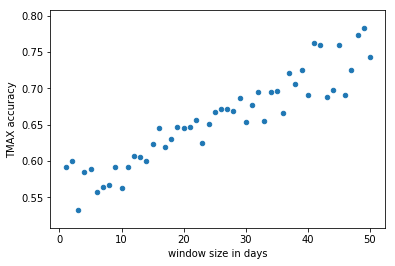

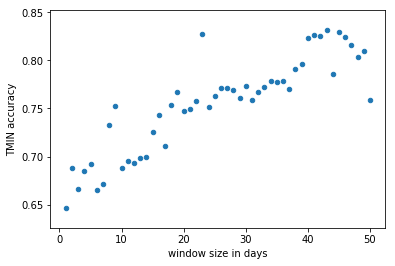

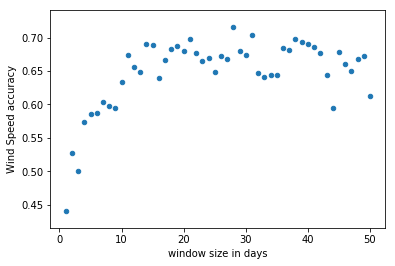

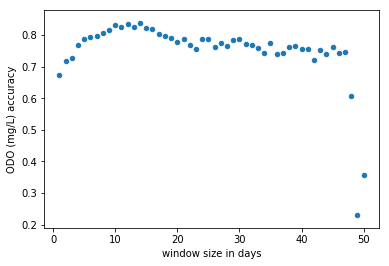

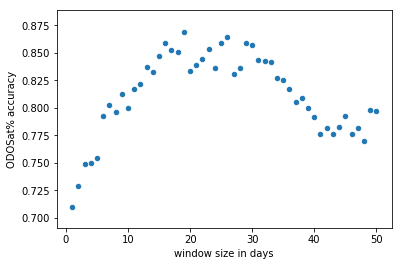

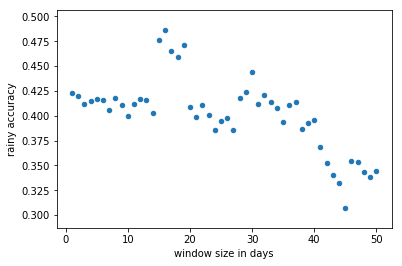

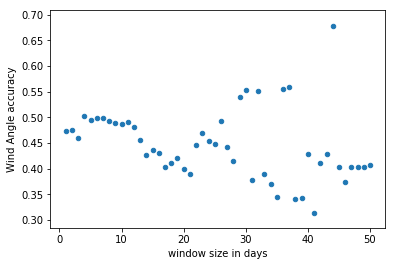

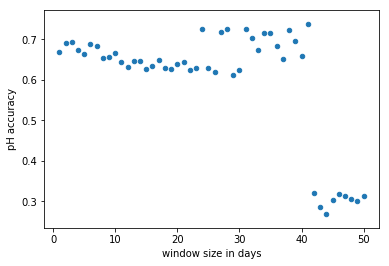

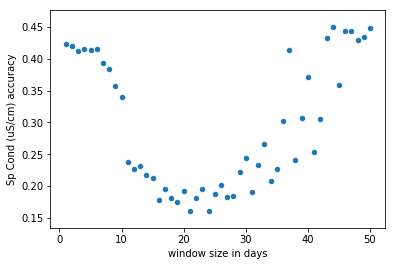

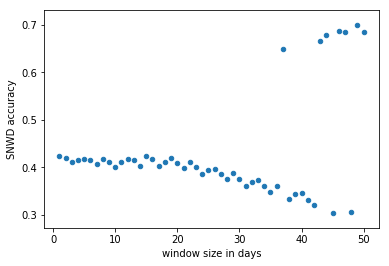

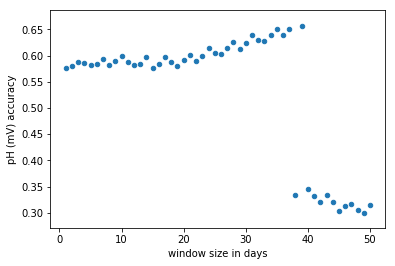

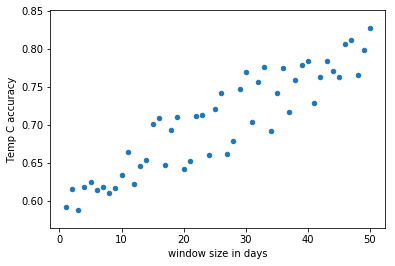

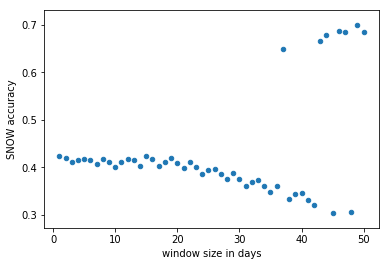

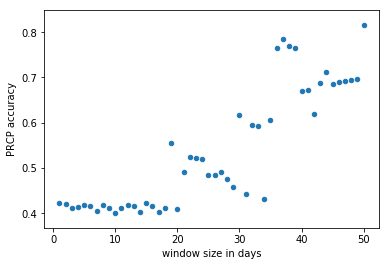

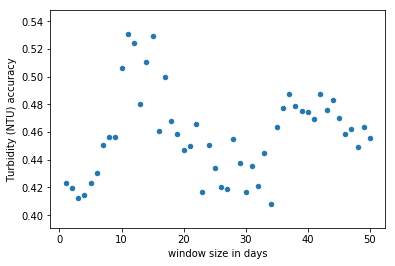

In [37]:
# Plot the accuracies vs window size for each column
sizes = [x.days for x in window_sizes]
for col in x_columns:
    df = pd.DataFrame({col + " accuracy": accuracies[col], 
                           "window size in days": sizes})
    df.plot(kind="scatter", y=col + " accuracy", x="window size in days")

## Greedy Custom Window Size
Create a greedy model using the best custom window sizes found above.

In [38]:
# add the weather columns to our x_columns
x_columns = list(set(x_columns + 
                     ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 
                      'rainy', 'Wind Speed', 'Wind Angle']))

max_iter = 25000
loss = "log"

parameters = dict()
for col, x_win in best_x_windows.items():
    print(col, x_win)
    parameters[col] = {'x_win_size':x_win}

# Windowize
print("Windowizing 2017 data set:", train_index)
train = hf.windowize(train_dfs[train_index], 'datetime', 
                     target_column, custom_parameters=parameters)
print("Windowizing 2018 data set:", test_index)
test = hf.windowize(test_dfs[test_index], 'datetime', 
                    target_column, custom_parameters=parameters)
print()

#Add rainy column
for df in [test, train]:
    df['rainy'] = df['PRCP'].apply(
        lambda x: 1 if x > 0 else 0).astype('category')

#Add target columns
lrf.add_target_column([train, test], threshold=RFU_THRESHOLD)

# Sort columns by accuracy
model = SGDClassifier(max_iter=max_iter, loss=loss)
sorted_columns = lrf.sort_columns_by_metric(model, train, 
                                            test,
                                            x_columns,
                                            'bloom')
# Create greedy model
model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, predictions, _, _ = lrf.greedy_model(
    model, train, test, x_columns,'bloom', sorted_columns)
print("accuracy", accuracy)
print("recall", recall)
print("precision", precision)
print()

TMAX 29 days 00:00:00
TMIN 23 days 00:00:00
Wind Speed 28 days 00:00:00
ODO (mg/L) 14 days 00:00:00
ODOSat% 19 days 00:00:00
rainy 16 days 00:00:00
Wind Angle 30 days 00:00:00
pH 28 days 00:00:00
Sp Cond (uS/cm) 1 days 00:00:00
SNWD 15 days 00:00:00
pH (mV) 28 days 00:00:00
Temp C 30 days 00:00:00
SNOW 15 days 00:00:00
PRCP 30 days 00:00:00
Turbidity (NTU) 11 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model with: TMAX
Accuracy 0.6508474576271186
Recall: 0.6793478260869565
Precision 0.7396449704142012
Confusion Matrix:
 [[ 67  44]
 [ 59 125]]

Training model with: Wind Speed
Accuracy 0.6779661016949152
Recall: 0.7065217391304348
Precision 0.7602339181286549
Confusion Matrix:
 [[ 70  41]
 [ 54 130]]

Training model with: ODO (mg/L)
Accuracy 0.88474576271186

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.376271186440678
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[111   0]
 [184   0]]

Training model with: Sp Cond (uS/cm)
Accuracy 0.2576271186440678
Recall: 0.021739130434782608
Precision 0.09302325581395349
Confusion Matrix:
 [[ 72  39]
 [180   4]]

Training model with: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.376271186440678
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[111   0]
 [184   0]]

Training model with: Turbidity (NTU)
Accuracy 0.535593220338983
Recall: 0.6684782608695652
Precision 0.6180904522613065
Confusion Matrix:
 [[ 35  76]
 [ 61 123]]

Training model with: pH (mV)
Accuracy 0.6237288135593221
Recall: 1.0
Precision 0.6237288135593221
Confusion Matrix:
 [[  0 111]
 [  0 184]]

Training model with: TMIN
Accuracy 0.8203389830508474
Recall: 0.875
Precision 0.8429319371727748
Confusion Matrix:
 [[ 81  30]
 [ 23 161]]

Training model with: rainy
Accuracy 0.4440677966101695
Recall: 0.1956521739130435
Precision 0.6923076923076923
Confusion Matrix:
 [[ 95  16]
 [148  36]]

Training model with: Temp C
Accuracy 0.7694915254237288
Recall: 0.6956521739130435
Precision 0.9142857142857143
Confusion Matrix:
 [[ 99  12]
 [ 56 128]]

ODO (mg/L) metric value: 0.8847457627118644
ODOSat% metric value: 0.8542372881355932
TMIN metric value: 0.8203389830508474
Temp C metric value: 0.76949

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODO (mg/L)', 'ODOSat%', 'TMIN', 'Temp C', 'Wind Speed', 'TMAX', 'pH', 'pH (mV)', 'PRCP', 'Wind Angle', 'Turbidity (NTU)', 'rainy', 'SNOW', 'SNWD', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODO (mg/L)', 'ODOSat%', 'TMIN', 'Temp C', 'Wind Speed', 'TMAX', 'pH', 'pH (mV)', 'PRCP', 'Wind Angle', 'Turbidity (NTU)', 'rainy', 'SNOW', 'SNWD', 'Sp Cond (uS/cm)']
Training model with: ['ODO (mg/L)']
Test model accuracy: 0.8847457627118644
Test model recall: 0.8913043478260869
Test model precision: 0.9213483146067416

Updating greedy model

Training model with: ['ODO (mg/L)', 'ODOSat%']
Test model accuracy: 0.8847457627118644
Test model recall: 0.8804347826086957
Test model precision: 0.9310344827586207

Training model with: ['ODO (mg/L)', 'TMIN']
Test model accuracy: 0.8677966101694915
Test model recall: 0.875
Test model precision: 0.9096045197740112

Training model with: ['ODO (mg/L)', 'Temp C']
Test model accuracy: 0.8847457627118644
Test model recall: 0.88

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.376271186440678
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['ODO (mg/L)', 'Wind Speed', 'PRCP']
Test model accuracy: 0.8677966101694915
Test model recall: 0.8695652173913043
Test model precision: 0.9142857142857143

Training model with: ['ODO (mg/L)', 'Wind Speed', 'Wind Angle']
Test model accuracy: 0.6949152542372882
Test model recall: 0.592391304347826
Test model precision: 0.8790322580645161

Training model with: ['ODO (mg/L)', 'Wind Speed', 'Turbidity (NTU)']
Test model accuracy: 0.7830508474576271
Test model recall: 0.782608695652174
Test model precision: 0.8571428571428571

Training model with: ['ODO (mg/L)', 'Wind Speed', 'rainy']
Test model accuracy: 0.8542372881355932
Test model recall: 0.8641304347826086
Test model precision: 0.8983050847457628

Training model with: ['ODO (mg/L)', 'Wind Speed', 'SNOW']
Test model accuracy: 0.888135593220339
Test model recall: 0.8967391304347826
Test model precision: 0.9217877094972067

Traini

## Optimal Separation Size For Individual Features
Here we will use a constant window size of 7 days, but increase the x and y separation up to 43 days (7 + 43 = 50 day max window)

In [65]:
# add the weather columns to our x_columns
x_columns = list(set(x_columns + 
                     ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 
                      'rainy', 'Wind Speed', 'Wind Angle']))

iteration_delta = pd.Timedelta(1, unit='d')
max_x_window = pd.Timedelta(50, unit='d') 
current_y_window = pd.Timedelta(1, unit='d')
current_separation = pd.Timedelta(0)
best_accuracy = 0
best_recall = 0
best_precision = 0
best_x_window = iteration_delta
best_y_window = current_y_window
accuracies = dict()
best_accuracies = dict()
separations = []

max_x_window_size_for_use = pd.Timedelta(30, unit='d')
best_sep = dict()

max_iter = 25000
loss = "log"

current_x_window = pd.Timedelta('7 days')
while current_x_window + current_separation <= max_x_window:
    
    # Windowize
    print("current separation", current_separation)
    print("Windowizing 2017 data set:", train_index)
    train = hf.windowize(
        train_dfs[train_index], 'datetime', target_column, 
        x_win_size=current_x_window, y_win_size=current_y_window, 
        separation=current_separation)
    print("Windowizing 2018 data set:", test_index)
    test = hf.windowize(
        test_dfs[test_index], 'datetime', target_column,
        x_win_size=current_x_window, y_win_size=current_y_window,
        separation=current_separation)
    print()

    #Add rainy column
    for df in [test, train]:
        df['rainy'] = df['PRCP'].apply(
            lambda x: 1 if x > 0 else 0).astype('category')

    #Add target columns
    lrf.add_target_column([train, test], threshold=RFU_THRESHOLD)
    separations.append(current_separation)
    
    for col in x_columns:
        # Create model
        print("Training model on:", col)
        model = SGDClassifier(max_iter=max_iter, loss=loss)
        accuracy, recall, precision, cm, predictions, _, _ = lrf.train_model(
            model, train, test, [col],'bloom')
        print("accuracy", accuracy)
        print("recall", recall)
        print("precision", precision)
        print()
        if col not in accuracies:
            accuracies[col] = []
        if col not in best_accuracies or best_accuracies[col] < accuracy:
            if current_x_window + current_separation <= max_x_window_size_for_use:
                print("Updating best accuracy and shift size.")
                best_accuracies[col] = accuracy
                best_sep[col] = current_separation
        accuracies[col].append(accuracy)
    current_separation += iteration_delta

current separation 0 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.564179104477612
recall 0.40703517587939697
precision 0.7431192660550459

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.6716417910447762
recall 0.5376884422110553
precision 0.856

Updating best accuracy and window size.
Training model on: Wind Speed
accuracy 0.6029850746268657
recall 0.4321608040201005
precision 0.8113207547169812

Updating best accuracy and window size.
Training model on: ODO (mg/L)
accuracy 0.7970149253731343
recall 0.8391959798994975
precision 0.8226600985221675

Updating best accuracy and window size.
Training model on: ODOSat%
accuracy 0.8029850746268656
recall 0.7587939698492462
precision 0.893491124260355

Updating 

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4059701492537313
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: pH
accuracy 0.6835820895522388
recall 0.9396984924623115
precision 0.6654804270462633

Updating best accuracy and window size.
Training model on: Sp Cond (uS/cm)
accuracy 0.39104477611940297
recall 0.010050251256281407
precision 0.2222222222222222

Updating best accuracy and window size.
Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4059701492537313
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: pH (mV)
accuracy 0.5940298507462687
recall 1.0
precision 0.5940298507462687

Updating best accuracy and window size.
Training model on: Temp C
accuracy 0.6179104477611941
recall 0.4120603015075377
precision 0.8817204301075269

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4059701492537313
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4059701492537313
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: Turbidity (NTU)
accuracy 0.44776119402985076
recall 0.11055276381909548
precision 0.7333333333333333

Updating best accuracy and window size.
current separation 1 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6276276276276276
recall 0.6030927835051546
precision 0.7134146341463414

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.7417417417417418
recall 0.6958762886597938
precision 0.8333333333333334

Updating best accuracy and window size.
Training model on: Wind Speed
accuracy 0.5765765765765766
recall 0.41237113402061853
precision 0.7476635514018691

Training model on: ODO (mg/L)
accuracy 0.792

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4174174174174174
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: pH
accuracy 0.6726726726726727
recall 0.9381443298969072
precision 0.6523297491039427

Training model on: Sp Cond (uS/cm)
accuracy 0.37537537537537535
recall 0.02577319587628866
precision 0.20833333333333334

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4174174174174174
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: pH (mV)
accuracy 0.5825825825825826
recall 1.0
precision 0.5825825825825826

Training model on: Temp C
accuracy 0.6396396396396397
recall 0.520618556701031
precision 0.7890625

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4174174174174174
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4174174174174174
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: Turbidity (NTU)
accuracy 0.46546546546546547
recall 0.28865979381443296
precision 0.5833333333333334

Updating best accuracy and window size.
current separation 2 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6525679758308157
recall 0.6256410256410256
precision 0.7439024390243902

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.7613293051359517
recall 0.7128205128205128
precision 0.8580246913580247

Updating best accuracy and window size.
Training model on: Wind Speed
accuracy 0.5921450151057401
recall 0.46153846153846156
precision 0.75

Training model on: ODO (mg/L)
accuracy 0.8126888217522659


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4108761329305136
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.6646525679758308
recall 0.9333333333333333
precision 0.65

Training model on: Sp Cond (uS/cm)
accuracy 0.3202416918429003
recall 0.020512820512820513
precision 0.10526315789473684

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4108761329305136
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5891238670694864
recall 1.0
precision 0.5891238670694864

Training model on: Temp C
accuracy 0.6676737160120846
recall 0.558974358974359
precision 0.8195488721804511

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4108761329305136
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4108761329305136
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4622356495468278
recall 0.3282051282051282
precision 0.5765765765765766

current separation 3 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.5818181818181818
recall 0.5151515151515151
precision 0.7083333333333334

Training model on: TMIN
accuracy 0.7
recall 0.5656565656565656
precision 0.896

Training model on: Wind Speed
accuracy 0.5666666666666667
recall 0.398989898989899
precision 0.7669902912621359

Training model on: ODO (mg/L)
accuracy 0.796969696969697
recall 0.8181818181818182
precision 0.8393782383419689

Training model on: ODOSat%
accuracy 0.806060606060606
recall 0.7373737373737373
precision 0.9240506329113924

Training mode

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.6818181818181818
recall 0.9292929292929293
precision 0.6690909090909091

Training model on: Sp Cond (uS/cm)
accuracy 0.3090909090909091
recall 0.020202020202020204
precision 0.10526315789473684

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6
recall 1.0
precision 0.6

Updating best accuracy and window size.
Training model on: Temp C
accuracy 0.6545454545454545
recall 0.45454545454545453
precision 0.9375

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.46060606060606063
recall 0.29797979797979796
precision 0.6020408163265306

current separation 4 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6554878048780488
recall 0.6321243523316062
precision 0.7439024390243902

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.7469512195121951
recall 0.7046632124352331
precision 0.8395061728395061

Training model on: Wind Speed
accuracy 0.5853658536585366
recall 0.45077720207253885
precision 0.7435897435897436

Training model on: ODO (mg/L)
accuracy 0.8201219512195121
recall 0.8549222797927462
precision 0.8418367346938775

Updating best accuracy and window size.
Training model on: ODOSat

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4115853658536585
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.6676829268292683
recall 0.927461139896373
precision 0.6532846715328468

Training model on: Sp Cond (uS/cm)
accuracy 0.21951219512195122
recall 0.025906735751295335
precision 0.0684931506849315

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4115853658536585
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5884146341463414
recall 1.0
precision 0.5884146341463414

Training model on: Temp C
accuracy 0.649390243902439
recall 0.5077720207253886
precision 0.8305084745762712

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4115853658536585
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4115853658536585
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.5
recall 0.41450777202072536
precision 0.6106870229007634

Updating best accuracy and window size.
current separation 5 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6687116564417178
recall 0.6473684210526316
precision 0.75

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.754601226993865
recall 0.7157894736842105
precision 0.8395061728395061

Training model on: Wind Speed
accuracy 0.5736196319018405
recall 0.4421052631578947
precision 0.717948717948718

Training model on: ODO (mg/L)
accuracy 0.8128834355828221
recall 0.8421052631578947
precision 0.837696335078534

Training model on: ODOSat%
accuracy 0.865030

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4171779141104294
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.6625766871165644
recall 0.9263157894736842
precision 0.6470588235294118

Training model on: Sp Cond (uS/cm)
accuracy 0.19325153374233128
recall 0.021052631578947368
precision 0.04938271604938271

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4171779141104294
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5828220858895705
recall 1.0
precision 0.5828220858895705

Training model on: Temp C
accuracy 0.6809815950920245
recall 0.5789473684210527
precision 0.8208955223880597

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4171779141104294
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4171779141104294
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4662576687116564
recall 0.39473684210526316
precision 0.5597014925373134

current separation 6 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6246153846153846
recall 0.5578947368421052
precision 0.7361111111111112

Training model on: TMIN
accuracy 0.7107692307692308
recall 0.5736842105263158
precision 0.8934426229508197

Training model on: Wind Speed
accuracy 0.5784615384615385
recall 0.4
precision 0.7676767676767676

Training model on: ODO (mg/L)
accuracy 0.7692307692307693
recall 0.7789473684210526
precision 0.8176795580110497

Training model on: ODOSat%
accuracy 0.8523076923076923
recall 0.7894736842105263
precision 0.94936708860759

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4153846153846154
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.68
recall 0.9315789473684211
precision 0.6604477611940298

Training model on: Sp Cond (uS/cm)
accuracy 0.26153846153846155
recall 0.021052631578947368
precision 0.06896551724137931

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4153846153846154
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5846153846153846
recall 1.0
precision 0.5846153846153846

Training model on: Temp C
accuracy 0.6707692307692308
recall 0.46842105263157896
precision 0.9368421052631579

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4153846153846154
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4153846153846154
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.46153846153846156
recall 0.3473684210526316
precision 0.5641025641025641

current separation 7 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6253869969040248
recall 0.5595854922279793
precision 0.75

Training model on: TMIN
accuracy 0.7120743034055728
recall 0.5751295336787565
precision 0.9098360655737705

Training model on: Wind Speed
accuracy 0.5820433436532507
recall 0.43523316062176165
precision 0.7636363636363637

Training model on: ODO (mg/L)
accuracy 0.7523219814241486
recall 0.7512953367875648
precision 0.8192090395480226

Training model on: ODOSat%
accuracy 0.848297213622291
recall 0.7823834196891192
precision 0.9556962025316

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4024767801857585
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.6594427244582043
recall 0.9015544041450777
precision 0.6566037735849056

Training model on: Sp Cond (uS/cm)
accuracy 0.24458204334365324
recall 0.025906735751295335
precision 0.08196721311475409

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4024767801857585
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5975232198142415
recall 1.0
precision 0.5975232198142415

Training model on: Temp C
accuracy 0.6687306501547987
recall 0.47150259067357514
precision 0.9479166666666666

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4024767801857585
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4024767801857585
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4613003095975232
recall 0.35233160621761656
precision 0.5811965811965812

current separation 8 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6915887850467289
recall 0.6756756756756757
precision 0.7621951219512195

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.7383177570093458
recall 0.6108108108108108
precision 0.904

Training model on: Wind Speed
accuracy 0.6074766355140186
recall 0.4864864864864865
precision 0.743801652892562

Updating best accuracy and window size.
Training model on: ODO (mg/L)
accuracy 0.7258566978193146
recall 0.7513513513513513
precision 0.7679558011049724

Training model on: ODOSat%

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4236760124610592
recall 0.0
precision 0.0

Training model on: rainy
accuracy 0.5607476635514018
recall 0.5567567567567567
precision 0.6358024691358025

Updating best accuracy and window size.
Training model on: pH
accuracy 0.660436137071651
recall 0.9243243243243243
precision 0.6428571428571429

Training model on: Sp Cond (uS/cm)
accuracy 0.22741433021806853
recall 0.02702702702702703
precision 0.0684931506849315

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4236760124610592
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: pH (mV)
accuracy 0.5763239875389408
recall 1.0
precision 0.5763239875389408

Training model on: Temp C
accuracy 0.6822429906542056
recall 0.5675675675675675
precision 0.8267716535433071

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4236760124610592
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: PRCP
accuracy 0.5607476635514018
recall 0.5567567567567567
precision 0.6358024691358025

Updating best accuracy and window size.
Training model on: Turbidity (NTU)
accuracy 0.470404984423676
recall 0.3945945945945946
precision 0.5572519083969466

current separation 9 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7115987460815048
recall 0.6935483870967742
precision 0.7865853658536586

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.8244514106583072
recall 0.7849462365591398
precision 0.9012345679012346

Updating best accuracy and window size.
Training model on: Wind Speed
accuracy 0.5768025078369

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4169278996865204
recall 0.0
precision 0.0

Training model on: rainy
accuracy 0.542319749216301
recall 0.5376344086021505
precision 0.625

Training model on: pH
accuracy 0.677115987460815
recall 0.9354838709677419
precision 0.6566037735849056

Training model on: Sp Cond (uS/cm)
accuracy 0.21316614420062696
recall 0.021505376344086023
precision 0.0547945205479452

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4169278996865204
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5830721003134797
recall 1.0
precision 0.5830721003134797

Training model on: Temp C
accuracy 0.7115987460815048
recall 0.6075268817204301
precision 0.8560606060606061

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4169278996865204
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.5799373040752351
recall 0.6397849462365591
precision 0.6397849462365591

Updating best accuracy and window size.
Training model on: Turbidity (NTU)
accuracy 0.44200626959247646
recall 0.42473118279569894
precision 0.5266666666666666

current separation 10 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6415094339622641
recall 0.5789473684210527
precision 0.7638888888888888

Training model on: TMIN
accuracy 0.7264150943396226
recall 0.6
precision 0.912

Training model on: Wind Speed
accuracy 0.5754716981132075
recall 0.4263157894736842
precision 0.7570093457943925

Training model on: ODO (mg/L)
accuracy 0.6415094339622641
recall 0.4368421052631579


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4025157232704403
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5974842767295597
recall 1.0
precision 0.5974842767295597

Training model on: Temp C
accuracy 0.6761006289308176
recall 0.4789473684210526
precision 0.9578947368421052

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4025157232704403
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4025157232704403
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4308176100628931
recall 0.32105263157894737
precision 0.5398230088495575

current separation 11 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7215189873417721
recall 0.7043010752688172
precision 0.7987804878048781

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.8227848101265823
recall 0.7849462365591398
precision 0.9012345679012346

Training model on: Wind Speed
accuracy 0.5664556962025317
recall 0.42473118279569894
precision 0.7247706422018348

Training model on: ODO (mg/L)
accuracy 0.5854430379746836
recall 0.3225806451612903
precision 0.9230769230769231

Training model on: ODOSat%
accuracy 0.810126582278

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.41139240506329117
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5886075949367089
recall 1.0
precision 0.5886075949367089

Training model on: Temp C
accuracy 0.6962025316455697
recall 0.543010752688172
precision 0.9017857142857143

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.41139240506329117
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.41139240506329117
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4462025316455696
recall 0.3709677419354839
precision 0.5433070866141733

current separation 12 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7388535031847133
recall 0.7252747252747253
precision 0.8048780487804879

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.8343949044585988
recall 0.8021978021978022
precision 0.9012345679012346

Updating best accuracy and window size.
Training model on: Wind Speed
accuracy 0.5828025477707006
recall 0.43956043956043955
precision 0.7339449541284404

Training model on: ODO (mg/L)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.42038216560509556
recall 0.0
precision 0.0

Training model on: ODOSat%
accuracy 0.821656050955414
recall 0.7637362637362637
precision 0.9144736842105263

Training model on: Wind Angle
accuracy 0.4171974522292994
recall 0.17582417582417584
precision 0.49230769230769234

Training model on: rainy
accuracy 0.49363057324840764
recall 0.489010989010989
precision 0.5741935483870968

Training model on: pH
accuracy 0.6847133757961783
recall 0.9230769230769231
precision 0.6640316205533597

Training model on: Sp Cond (uS/cm)
accuracy 0.18789808917197454
recall 0.02197802197802198
precision 0.04938271604938271

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.42038216560509556
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5796178343949044
recall 1.0
precision 0.5796178343949044

Training model on: Temp C
accuracy 0.7006369426751592
recall 0.6043956043956044
precision 0.8333333333333334

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.42038216560509556
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.42038216560509556
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.46178343949044587
recall 0.3956043956043956
precision 0.549618320610687

current separation 13 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6837060702875399
recall 0.6216216216216216
precision 0.7986111111111112

Training model on: TMIN
accuracy 0.7699680511182109
recall 0.6432432432432432
precision 0.952

Training model on: Wind Speed
accuracy 0.5782747603833865
recall 0.372972972972973
precision 0.8117647058823529

Training model on: ODO (mg/L)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40894568690095845
recall 0.0
precision 0.0

Training model on: ODOSat%
accuracy 0.6741214057507987
recall 0.4918918918918919
precision 0.9191919191919192

Training model on: Wind Angle
accuracy 0.41533546325878595
recall 0.1783783783783784
precision 0.515625

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40894568690095845
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.7156549520766773
recall 0.9297297297297298
precision 0.6935483870967742

Updating best accuracy and window size.
Training model on: Sp Cond (uS/cm)
accuracy 0.24920127795527156
recall 0.021621621621621623
precision 0.06896551724137931

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40894568690095845
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5910543130990416
recall 1.0
precision 0.5910543130990416

Training model on: Temp C
accuracy 0.6964856230031949
recall 0.4918918918918919
precision 0.9891304347826086

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40894568690095845
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40894568690095845
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4281150159744409
recall 0.2756756756756757
precision 0.53125

current separation 14 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6881028938906752
recall 0.6256684491978609
precision 0.8125

Training model on: TMIN
accuracy 0.7620578778135049
recall 0.6363636363636364
precision 0.952

Training model on: Wind Speed
accuracy 0.5337620578778135
recall 0.2887700534759358
precision 0.8181818181818182

Training model on: ODO (mg/L)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3987138263665595
recall 0.0
precision 0.0

Training model on: ODOSat%
accuracy 0.5819935691318328
recall 0.3315508021390374
precision 0.9253731343283582

Training model on: Wind Angle
accuracy 0.4212218649517685
recall 0.19786096256684493
precision 0.5522388059701493

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3987138263665595
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.7106109324758842
recall 0.8983957219251337
precision 0.702928870292887

Training model on: Sp Cond (uS/cm)
accuracy 0.24115755627009647
recall 0.026737967914438502
precision 0.0847457627118644

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3987138263665595
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6012861736334405
recall 1.0
precision 0.6012861736334405

Updating best accuracy and window size.
Training model on: Temp C
accuracy 0.6816720257234726
recall 0.48128342245989303
precision 0.9782608695652174

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3987138263665595
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3987138263665595
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.40514469453376206
recall 0.19786096256684493
precision 0.5138888888888888

current separation 15 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7799352750809061
recall 0.7637362637362637
precision 0.8475609756097561

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.8576051779935275
recall 0.8241758241758241
precision 0.9259259259259259

Updating best accuracy and window size.
Training model on: Wind Speed
accuracy 0.5857605177993528
recall 0.3791208791208791
precision 0.8214285714285714

Training model on: ODO (mg/L)
accuracy 0.3818770226537217
recall 0.06043956043956044
precision 0.3548387096774194

Training 

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4110032362459547
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.7346278317152104
recall 0.9560439560439561
precision 0.7016129032258065

Updating best accuracy and window size.
Training model on: Sp Cond (uS/cm)
accuracy 0.22653721682847897
recall 0.04945054945054945
precision 0.12

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4110032362459547
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5889967637540453
recall 1.0
precision 0.5889967637540453

Training model on: Temp C
accuracy 0.7119741100323624
recall 0.5769230769230769
precision 0.8974358974358975

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4110032362459547
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4110032362459547
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.47249190938511326
recall 0.3241758241758242
precision 0.5959595959595959

current separation 16 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.8436482084690554
recall 0.842391304347826
precision 0.8908045977011494

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.8566775244299675
recall 0.8206521739130435
precision 0.9320987654320988

Training model on: Wind Speed
accuracy 0.49185667752442996
recall 0.1956521739130435
precision 0.8181818181818182

Training model on: ODO (mg/L)
accuracy 0.36482084690553745
recall 0.11956521739130435
precision 0.4

Training model on: ODOSat%


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4006514657980456
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.48534201954397393
recall 0.375
precision 0.6160714285714286

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4006514657980456
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.755700325732899
recall 0.9728260869565217
precision 0.7188755020080321

Updating best accuracy and window size.
Training model on: Sp Cond (uS/cm)
accuracy 0.22149837133550487
recall 0.04891304347826087
precision 0.1232876712328767

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4006514657980456
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5993485342019544
recall 1.0
precision 0.5993485342019544

Training model on: Temp C
accuracy 0.745928338762215
recall 0.657608695652174
precision 0.8897058823529411

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4006514657980456
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4006514657980456
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4234527687296417
recall 0.22826086956521738
precision 0.5454545454545454

current separation 17 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.738562091503268
recall 0.6702127659574468
precision 0.875

Training model on: TMIN
accuracy 0.7549019607843137
recall 0.6329787234042553
precision 0.952

Training model on: Wind Speed


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38562091503267976
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.38235294117647056
recall 0.10106382978723404
precision 0.48717948717948717

Training model on: ODOSat%


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38562091503267976
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.4019607843137255
recall 0.18085106382978725
precision 0.5396825396825397

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38562091503267976
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.8006535947712419
recall 0.8723404255319149
precision 0.8159203980099502

Updating best accuracy and window size.
Training model on: Sp Cond (uS/cm)
accuracy 0.28431372549019607
recall 0.03723404255319149
precision 0.15555555555555556

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38562091503267976
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6143790849673203
recall 1.0
precision 0.6143790849673203

Updating best accuracy and window size.
Training model on: Temp C
accuracy 0.6830065359477124
recall 0.48936170212765956
precision 0.989247311827957

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38562091503267976
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38562091503267976
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.3790849673202614
recall 0.0
precision 0.0

current separation 18 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.8223684210526315
recall 0.7989130434782609
precision 0.8963414634146342

Training model on: TMIN
accuracy 0.8223684210526315
recall 0.7934782608695652
precision 0.9012345679012346

Training model on: Wind Speed


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39473684210526316
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.3684210526315789
recall 0.14673913043478262
precision 0.43548387096774194

Training model on: ODOSat%


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39473684210526316
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.40460526315789475
recall 0.1793478260869565
precision 0.5238095238095238

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39473684210526316
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.7894736842105263
recall 0.9021739130434783
precision 0.7830188679245284

Training model on: Sp Cond (uS/cm)
accuracy 0.2138157894736842
recall 0.04891304347826087
precision 0.1232876712328767

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39473684210526316
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6052631578947368
recall 1.0
precision 0.6052631578947368

Training model on: Temp C
accuracy 0.7105263157894737
recall 0.5815217391304348
precision 0.9067796610169492

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39473684210526316
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.4868421052631579
recall 0.4945652173913043
precision 0.5909090909090909

Training model on: Turbidity (NTU)
accuracy 0.40460526315789475
recall 0.04891304347826087
precision 0.6

current separation 19 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.8344370860927153
recall 0.8131868131868132
precision 0.9024390243902439

Training model on: TMIN
accuracy 0.8211920529801324
recall 0.7967032967032966
precision 0.8950617283950617

Training model on: Wind Speed


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3973509933774834
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.3708609271523179
recall 0.18681318681318682
precision 0.4473684210526316

Training model on: ODOSat%


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3973509933774834
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.39403973509933776
recall 0.15384615384615385
precision 0.49122807017543857

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3973509933774834
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.7980132450331126
recall 0.8846153846153846
precision 0.8009950248756219

Training model on: Sp Cond (uS/cm)
accuracy 0.18211920529801323
recall 0.04395604395604396
precision 0.09876543209876543

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3973509933774834
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6026490066225165
recall 1.0
precision 0.6026490066225165

Training model on: Temp C
accuracy 0.7615894039735099
recall 0.6758241758241759
precision 0.9044117647058824

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3973509933774834
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3973509933774834
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4470198675496689
recall 0.19230769230769232
precision 0.6363636363636364

current separation 20 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.770764119601329
recall 0.7027027027027027
precision 0.9027777777777778

Training model on: TMIN
accuracy 0.7375415282392026
recall 0.6162162162162163
precision 0.9344262295081968

Training model on: Wind Speed


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3853820598006645
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.38205980066445183
recall 0.10270270270270271
precision 0.48717948717948717

Training model on: ODOSat%


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3853820598006645
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.37209302325581395
recall 0.11891891891891893
precision 0.4583333333333333

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3853820598006645
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.49169435215946844
recall 0.2
precision 0.8809523809523809

Training model on: Sp Cond (uS/cm)
accuracy 0.3023255813953488
recall 0.043243243243243246
precision 0.1951219512195122

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3853820598006645
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6146179401993356
recall 1.0
precision 0.6146179401993356

Updating best accuracy and window size.
Training model on: Temp C
accuracy 0.6877076411960132
recall 0.4972972972972973
precision 0.989247311827957

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3853820598006645
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3853820598006645
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3853820598006645
recall 0.0
precision 0.0

current separation 21 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7558528428093646
recall 0.6898395721925134
precision 0.8958333333333334

Training model on: TMIN
accuracy 0.745819397993311
recall 0.6310160427807486
precision 0.944

Training model on: Wind Speed
accuracy 0.3411371237458194
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.3612040133779264
recall 0.11764705882352941
precision 0.4583333333333333

Training model on: ODOSat%


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3745819397993311
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.3712374581939799
recall 0.0962566844919786
precision 0.4864864864864865

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3745819397993311
recall 0.0
precision 0.0

Training model on: pH


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3745819397993311
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.19732441471571907
recall 0.053475935828877004
precision 0.136986301369863

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3745819397993311
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6254180602006689
recall 1.0
precision 0.6254180602006689

Updating best accuracy and window size.
Training model on: Temp C
accuracy 0.6989966555183946
recall 0.5240641711229946
precision 0.98989898989899

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3745819397993311
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3745819397993311
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3745819397993311
recall 0.0
precision 0.0

current separation 22 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.8181818181818182
recall 0.8021978021978022
precision 0.8902439024390244

Training model on: TMIN
accuracy 0.7845117845117845
recall 0.7692307692307693
precision 0.8641975308641975

Training model on: Wind Speed
accuracy 0.3434343434343434
recall 0.03296703296703297
precision 0.24

Training model on: ODO (mg/L)
accuracy 0.3333333333333333
recall 0.15934065934065933
precision 0.3918918918918919

Training model on: ODOSat%
accuracy 0.3434343434343434
recall 0.038461538461538464
precision 0.25925925925925924

Training model on: Wind Angle
accuracy 0.37373737373737376
recall 0.0
precision 0.0

Training model on: rainy

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3872053872053872
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.16161616161616163
recall 0.07142857142857142
precision 0.13978494623655913

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3872053872053872
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6127946127946128
recall 1.0
precision 0.6127946127946128

Training model on: Temp C
accuracy 0.8013468013468014
recall 0.7142857142857143
precision 0.948905109489051

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3872053872053872
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3872053872053872
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3872053872053872
recall 0.0
precision 0.0

current separation 23 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7966101694915254
recall 0.8097826086956522
precision 0.8563218390804598

Training model on: TMIN
accuracy 0.7864406779661017
recall 0.8043478260869565
precision 0.8457142857142858

Training model on: Wind Speed
accuracy 0.3423728813559322
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.3254237288135593
recall 0.19021739130434784
precision 0.4117647058823529

Training model on: ODOSat%
accuracy 0.29152542372881357
recall 0.07065217391304347
precision 0.2549019607843137

Training model on: Wind Angle
accuracy 0.41694915254237286
recall 0.13043478260869565
precision 0.6666666666666666

Training mo

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.376271186440678
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.21694915254237288
recall 0.18478260869565216
precision 0.2956521739130435

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.376271186440678
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6237288135593221
recall 1.0
precision 0.6237288135593221

Training model on: Temp C
accuracy 0.823728813559322
recall 0.7934782608695652
precision 0.9125

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.376271186440678
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.5796610169491525
recall 0.75
precision 0.6388888888888888

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.376271186440678
recall 0.0
precision 0.0

current separation 24 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7619047619047619
recall 0.6968085106382979
precision 0.9097222222222222

Training model on: TMIN
accuracy 0.7755102040816326
recall 0.7553191489361702
precision 0.8765432098765432

Training model on: Wind Speed
accuracy 0.32653061224489793
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.30272108843537415
recall 0.10106382978723404
precision 0.34545454545454546

Training model on: ODOSat%


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.36054421768707484
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.40816326530612246
recall 0.13297872340425532
precision 0.6944444444444444

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.36054421768707484
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.3401360544217687
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.1870748299319728
recall 0.0797872340425532
precision 0.18518518518518517

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.36054421768707484
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.36054421768707484
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7210884353741497
recall 0.5904255319148937
precision 0.9568965517241379

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.36054421768707484
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.5918367346938775
recall 0.6595744680851063
precision 0.6888888888888889

Training model on: Turbidity (NTU)
accuracy 0.3877551020408163
recall 0.11170212765957446
precision 0.6176470588235294

current separation 25 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.773972602739726
recall 0.7934782608695652
precision 0.8390804597701149

Training model on: TMIN
accuracy 0.7876712328767124
recall 0.7989130434782609
precision 0.8546511627906976

Training model on: Wind Speed


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3698630136986301
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.3356164383561644
recall 0.1793478260869565
precision 0.4342105263157895

Training model on: ODOSat%
accuracy 0.339041095890411
recall 0.05434782608695652
precision 0.3448275862068966

Training model on: Wind Angle
accuracy 0.4383561643835616
recall 0.3695652173913043
precision 0.5862068965517241

Training model on: rainy
accuracy 0.5068493150684932
recall 0.5271739130434783
precision 0.6298701298701299

Training model on: pH
accuracy 0.3253424657534247
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.1678082191780822
recall 0.09782608695652174
precision 0.18947368421052632

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3698630136986301
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3698630136986301
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7773972602739726
recall 0.7010869565217391
precision 0.9280575539568345

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3698630136986301
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.5958904109589042
recall 0.7663043478260869
precision 0.6527777777777778

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3698630136986301
recall 0.0
precision 0.0

current separation 26 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7724137931034483
recall 0.7967032967032966
precision 0.8333333333333334

Training model on: TMIN
accuracy 0.7862068965517242
recall 0.7967032967032966
precision 0.8529411764705882

Training model on: Wind Speed
accuracy 0.4206896551724138
recall 0.07692307692307693
precision 1.0

Training model on: ODO (mg/L)
accuracy 0.32413793103448274
recall 0.18681318681318682
precision 0.4146341463414634

Training model on: ODOSat%
accuracy 0.32068965517241377
recall 0.08241758241758242
precision 0.3333333333333333

Training model on: Wind Angle
accuracy 0.49310344827586206
recall 0.46703296703296704
precision 0.629629629629

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3724137931034483
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3724137931034483
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7931034482758621
recall 0.7637362637362637
precision 0.8910256410256411

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3724137931034483
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.6206896551724138
recall 0.7912087912087912
precision 0.6666666666666666

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3724137931034483
recall 0.0
precision 0.0

current separation 27 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7474048442906575
recall 0.6918918918918919
precision 0.8888888888888888

Training model on: TMIN
accuracy 0.754325259515571
recall 0.745945945945946
precision 0.8518518518518519

Training model on: Wind Speed


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.35986159169550175
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.370242214532872
recall 0.1891891891891892
precision 0.5223880597014925

Training model on: ODOSat%
accuracy 0.32525951557093424
recall 0.043243243243243246
precision 0.3076923076923077

Training model on: Wind Angle
accuracy 0.43252595155709345
recall 0.3783783783783784
precision 0.5882352941176471

Training model on: rainy
accuracy 0.5397923875432526
recall 0.5567567567567567
precision 0.6688311688311688

Training model on: pH
accuracy 0.3079584775086505
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.17647058823529413
recall 0.10810810810810811
precision 0.21505376344086022

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.35986159169550175
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.35986159169550175
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7162629757785467
recall 0.5783783783783784
precision 0.963963963963964

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.35986159169550175
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.643598615916955
recall 0.8054054054054054
precision 0.6898148148148148

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.35986159169550175
recall 0.0
precision 0.0

current separation 28 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7804878048780488
recall 0.7700534759358288
precision 0.8780487804878049

Training model on: TMIN
accuracy 0.759581881533101
recall 0.7486631016042781
precision 0.8641975308641975

Training model on: Wind Speed


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.34843205574912894
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.3693379790940767
recall 0.20320855614973263
precision 0.5428571428571428

Training model on: ODOSat%
accuracy 0.30662020905923343
recall 0.058823529411764705
precision 0.3235294117647059

Training model on: Wind Angle
accuracy 0.43902439024390244
recall 0.42245989304812837
precision 0.5984848484848485

Training model on: rainy
accuracy 0.5400696864111498
recall 0.5561497326203209
precision 0.6797385620915033

Training model on: pH
accuracy 0.28222996515679444
recall 0.026737967914438502
precision 0.1724137931034483

Training model on: Sp Cond (uS/cm)
accuracy 0.16376306620209058
recall 0.10695187165775401
precision 0.21505376344086022

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.34843205574912894
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.34843205574912894
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7386759581881533
recall 0.6417112299465241
precision 0.9375

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.34843205574912894
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.6515679442508711
recall 0.8074866310160428
precision 0.7023255813953488

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.34843205574912894
recall 0.0
precision 0.0

current separation 29 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7614035087719299
recall 0.7912087912087912
precision 0.8275862068965517

Training model on: TMIN
accuracy 0.7578947368421053
recall 0.7637362637362637
precision 0.8424242424242424

Training model on: Wind Speed
accuracy 0.45263157894736844
recall 0.18681318681318682
precision 0.8095238095238095

Training model on: ODO (mg/L)
accuracy 0.35789473684210527
recall 0.22527472527472528
precision 0.4939759036144578

Training model on: ODOSat%
accuracy 0.24912280701754386
recall 0.17032967032967034
precision 0.32978723404255317

Training model on: Wind Angle
accuracy 0.48771929824561405
recall 0.5384615384615384
precisi

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.36140350877192984
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.36140350877192984
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7543859649122807
recall 0.7362637362637363
precision 0.8589743589743589

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.36140350877192984
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.6596491228070176
recall 0.8186813186813187
precision 0.6995305164319249

Training model on: Turbidity (NTU)
accuracy 0.4
recall 0.3021978021978022
precision 0.5555555555555556

current separation 30 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7597173144876325
recall 0.8043478260869565
precision 0.8222222222222222

Training model on: TMIN
accuracy 0.7491166077738516
recall 0.75
precision 0.8466257668711656

Training model on: Wind Speed
accuracy 0.6749116607773852
recall 0.8913043478260869
precision 0.6949152542372882

Training model on: ODO (mg/L)
accuracy 0.35335689045936397
recall 0.266304347826087
precision 0.5051546391752577

Training mod

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3498233215547703
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7703180212014135
recall 0.8043478260869565
precision 0.8361581920903954

Training model on: SNOW
accuracy 0.6501766784452296
recall 1.0
precision 0.6501766784452296

Training model on: PRCP
accuracy 0.6925795053003534
recall 0.8586956521739131
precision 0.7214611872146118

Training model on: Turbidity (NTU)
accuracy 0.5053003533568905
recall 0.625
precision 0.6182795698924731

current separation 31 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7730496453900709
recall 0.7659574468085106
precision 0.8780487804878049

Training model on: TMIN
accuracy 0.7588652482269503
recall 0.75
precision 0.8703703703703703

Training model on: Wind Speed
accura

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3333333333333333
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3333333333333333
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.6985815602836879
recall 0.6276595744680851
precision 0.8872180451127819

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3333333333333333
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.6808510638297872
recall 0.8191489361702128
precision 0.7333333333333333

Training model on: Turbidity (NTU)
accuracy 0.3900709219858156
recall 0.34574468085106386
precision 0.5701754385964912

current separation 32 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7714285714285715
recall 0.7989130434782609
precision 0.8448275862068966

Training model on: TMIN
accuracy 0.7535714285714286
recall 0.7554347826086957
precision 0.852760736196319

Training model on: Wind Speed


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.34285714285714286
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.38571428571428573
recall 0.2554347826086957
precision 0.573170731707317

Training model on: ODOSat%
accuracy 0.2785714285714286
recall 0.19021739130434784
precision 0.3977272727272727

Training model on: Wind Angle
accuracy 0.5178571428571429
recall 0.5543478260869565
precision 0.6580645161290323

Training model on: rainy
accuracy 0.5714285714285714
recall 0.5706521739130435
precision 0.7191780821917808

Training model on: pH
accuracy 0.26071428571428573
recall 0.02717391304347826
precision 0.15151515151515152

Training model on: Sp Cond (uS/cm)
accuracy 0.2892857142857143
recall 0.29347826086956524
precision 0.43902439024390244

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.34285714285714286
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.34285714285714286
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7035714285714286
recall 0.6521739130434783
precision 0.8633093525179856

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.34285714285714286
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.6857142857142857
recall 0.8260869565217391
precision 0.7307692307692307

Training model on: Turbidity (NTU)
accuracy 0.4392857142857143
recall 0.44021739130434784
precision 0.6

current separation 33 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7769784172661871
recall 0.8241758241758241
precision 0.8333333333333334

Training model on: TMIN
accuracy 0.7589928057553957
recall 0.7637362637362637
precision 0.852760736196319

Training model on: Wind Speed
accuracy 0.4136690647482014
recall 0.31868131868131866
precision 0.5979381443298969

Training model on: ODO (mg/L)
accuracy 0.35611510791366907
recall 0.2692307692307692
precision 0.51578947368421

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.34532374100719426
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.34532374100719426
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7482014388489209
recall 0.7472527472527473
precision 0.85

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.34532374100719426
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.7122302158273381
recall 0.8681318681318682
precision 0.7383177570093458

Training model on: Turbidity (NTU)
accuracy 0.5143884892086331
recall 0.6043956043956044
precision 0.6358381502890174

current separation 34 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7436823104693141
recall 0.6972972972972973
precision 0.8958333333333334

Training model on: TMIN
accuracy 0.7653429602888087
recall 0.7621621621621621
precision 0.8703703703703703

Training model on: Wind Speed
accuracy 0.2743682310469314
recall 0.010810810810810811
precision 0.1

Training model on: ODO (mg/L)
accuracy 0.4043321299638989
recall 0.2594594594594595
precision 0.63157894736842

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.33212996389891697
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.33212996389891697
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.6859205776173285
recall 0.5675675675675675
precision 0.9375

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.33212996389891697
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.6823104693140795
recall 0.8162162162162162
precision 0.7365853658536585

Training model on: Turbidity (NTU)
accuracy 0.36101083032490977
recall 0.05945945945945946
precision 0.7857142857142857

current separation 35 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.8072727272727273
recall 0.7967914438502673
precision 0.9085365853658537

Training model on: TMIN
accuracy 0.7636363636363637
recall 0.7593582887700535
precision 0.8765432098765432

Training model on: Wind Speed
accuracy 0.2909090909090909
recall 0.0053475935828877
precision 0.1

Training model on: ODO (mg/L)
accuracy 0.41454545454545455
recall 0.27807486631016043
precision 0.666666666666

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.32
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.32
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7054545454545454
recall 0.5989304812834224
precision 0.9491525423728814

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.32
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.6872727272727273
recall 0.8128342245989305
precision 0.7487684729064039

Training model on: Turbidity (NTU)
accuracy 0.3890909090909091
recall 0.3155080213903743
precision 0.5959595959595959

current separation 36 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.8241758241758241
recall 0.8626373626373627
precision 0.8722222222222222

Training model on: TMIN
accuracy 0.7619047619047619
recall 0.7692307692307693
precision 0.8588957055214724

Training model on: Wind Speed
accuracy 0.6190476190476191
recall 0.7967032967032966
precision 0.6839622641509434

Training model on: ODO (mg/L)
accuracy 0.39194139194139194
recall 0.3131868131868132
precision 0.581632653061224

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3333333333333333
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7509157509157509
recall 0.7582417582417582
precision 0.8518518518518519

Training model on: SNOW
accuracy 0.6666666666666666
recall 1.0
precision 0.6666666666666666

Training model on: PRCP
accuracy 0.6813186813186813
recall 0.8351648351648352
precision 0.7272727272727273

Training model on: Turbidity (NTU)
accuracy 0.5457875457875457
recall 0.6373626373626373
precision 0.6666666666666666

current separation 37 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.8339483394833949
recall 0.9402173913043478
precision 0.8357487922705314

Training model on: TMIN
accuracy 0.7675276752767528
recall 0.782608695652174
precision 0.8622754491017964

Training m

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3210332103321033
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7896678966789668
recall 0.8586956521739131
precision 0.8359788359788359

Training model on: SNOW
accuracy 0.6789667896678967
recall 1.0
precision 0.6789667896678967

Training model on: PRCP
accuracy 0.6863468634686347
recall 0.8369565217391305
precision 0.7368421052631579

Training model on: Turbidity (NTU)
accuracy 0.6678966789667896
recall 0.8206521739130435
precision 0.7259615384615384

current separation 38 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.8222222222222222
recall 0.8085106382978723
precision 0.926829268292683

Training model on: TMIN
accuracy 0.762962962962963
recall 0.7553191489361702
precision 0.8875

Training model on: Wind

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3037037037037037
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.45185185185185184
recall 0.324468085106383
precision 0.7439024390243902

Training model on: ODOSat%
accuracy 0.34074074074074073
recall 0.2978723404255319
precision 0.5490196078431373

Training model on: Wind Angle
accuracy 0.5296296296296297
recall 0.5478723404255319
precision 0.7103448275862069

Training model on: rainy
accuracy 0.5185185185185185
recall 0.5159574468085106
precision 0.7132352941176471

Training model on: pH
accuracy 0.22592592592592592
recall 0.03723404255319149
precision 0.2

Training model on: Sp Cond (uS/cm)
accuracy 0.3037037037037037
recall 0.31382978723404253
precision 0.5

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3037037037037037
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3037037037037037
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7037037037037037
recall 0.6382978723404256
precision 0.9090909090909091

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3037037037037037
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.674074074074074
recall 0.7925531914893617
precision 0.7525252525252525

Training model on: Turbidity (NTU)
accuracy 0.42592592592592593
recall 0.3882978723404255
precision 0.6460176991150443

current separation 39 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7947761194029851
recall 0.8586956521739131
precision 0.8449197860962567

Training model on: TMIN
accuracy 0.7313432835820896
recall 0.7336956521739131
precision 0.8544303797468354

Training model on: Wind Speed
accuracy 0.6865671641791045
recall 0.9728260869565217
precision 0.6937984496124031

Training model on: ODO (mg/L)
accuracy 0.4253731343283582
recall 0.34782608695652173
precision 0.6

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.31343283582089554
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7910447761194029
recall 0.8315217391304348
precision 0.8595505617977528

Training model on: SNOW
accuracy 0.6865671641791045
recall 1.0
precision 0.6865671641791045

Training model on: PRCP
accuracy 0.6865671641791045
recall 0.8315217391304348
precision 0.7427184466019418

Training model on: Turbidity (NTU)
accuracy 0.5597014925373134
recall 0.6413043478260869
precision 0.6941176470588235

current separation 40 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.8195488721804511
recall 0.9230769230769231
precision 0.8316831683168316

Training model on: TMIN
accuracy 0.7593984962406015
recall 0.8186813186813187
precision 0.8277777777777777

Training

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3157894736842105
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7669172932330827
recall 0.8296703296703297
precision 0.8296703296703297

Training model on: SNOW
accuracy 0.6842105263157895
recall 1.0
precision 0.6842105263157895

Training model on: PRCP
accuracy 0.6842105263157895
recall 0.8351648351648352
precision 0.7378640776699029

Training model on: Turbidity (NTU)
accuracy 0.631578947368421
recall 0.7252747252747253
precision 0.7333333333333333

current separation 41 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7962264150943397
recall 0.7989130434782609
precision 0.8963414634146342

Training model on: TMIN
accuracy 0.7094339622641509
recall 0.7119565217391305
precision 0.8451612903225807

Training m

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.30566037735849055
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.30566037735849055
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7358490566037735
recall 0.6793478260869565
precision 0.9191176470588235

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.30566037735849055
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.7018867924528301
recall 0.8315217391304348
precision 0.7611940298507462

Training model on: Turbidity (NTU)
accuracy 0.5849056603773585
recall 0.625
precision 0.7371794871794872

current separation 42 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7908745247148289
recall 0.842391304347826
precision 0.856353591160221

Training model on: TMIN
accuracy 0.7680608365019012
recall 0.8586956521739131
precision 0.8186528497409327

Training model on: Wind Speed
accuracy 0.5741444866920152
recall 0.717391304347826
precision 0.6875

Training model on: ODO (mg/L)
accuracy 0.4524714828897338
recall 0.3695652173913043
precision 0.7083333333333334

Training mo

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.30038022813688214
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.8060836501901141
recall 0.8315217391304348
precision 0.884393063583815

Training model on: SNOW
accuracy 0.6996197718631179
recall 1.0
precision 0.6996197718631179

Training model on: PRCP
accuracy 0.7224334600760456
recall 0.8478260869565217
precision 0.7761194029850746

Training model on: Turbidity (NTU)
accuracy 0.6159695817490495
recall 0.6684782608695652
precision 0.754601226993865

current separation 43 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.685823754789272
recall 1.0
precision 0.685823754789272

Training model on: TMIN
accuracy 0.685823754789272
recall 1.0
precision 0.685823754789272

Training model on: Wind Speed
accuracy 0.708

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.31417624521072796
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.789272030651341
recall 0.9385474860335196
precision 0.7924528301886793

Training model on: SNOW
accuracy 0.685823754789272
recall 1.0
precision 0.685823754789272

Training model on: PRCP
accuracy 0.7318007662835249
recall 1.0
precision 0.7188755020080321

Training model on: Turbidity (NTU)
accuracy 0.6973180076628352
recall 0.7988826815642458
precision 0.7688172043010753



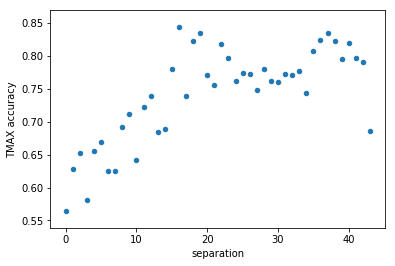

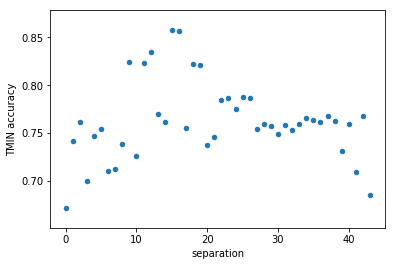

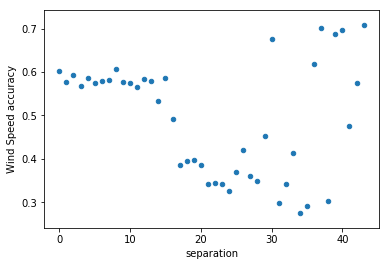

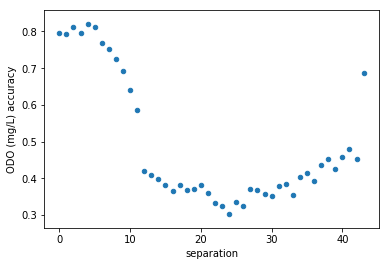

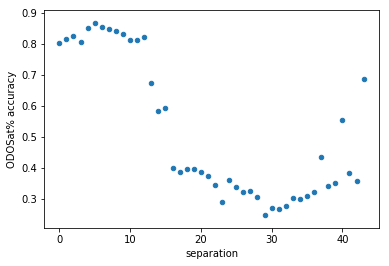

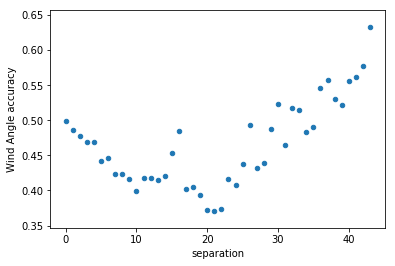

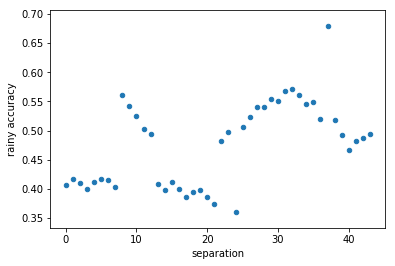

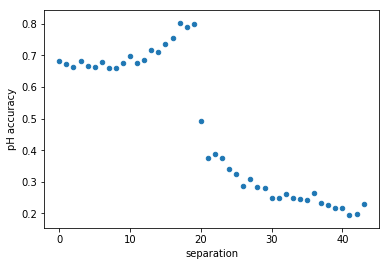

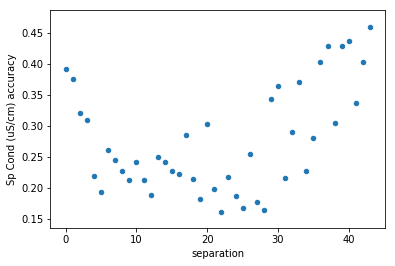

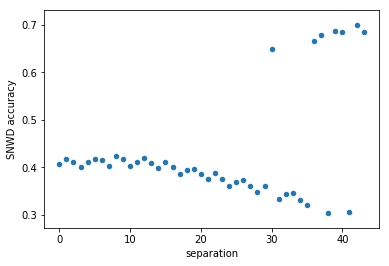

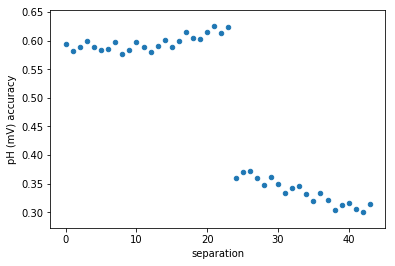

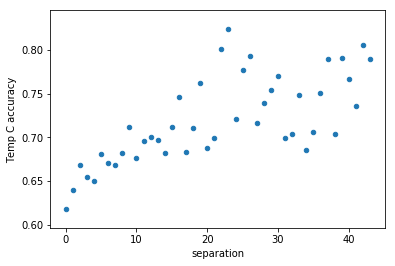

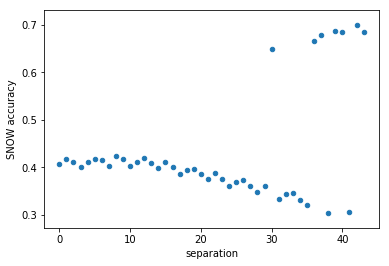

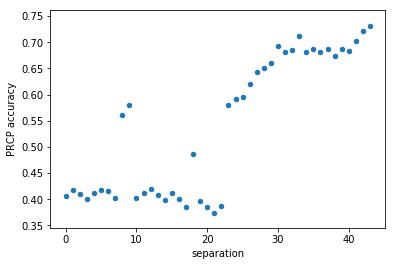

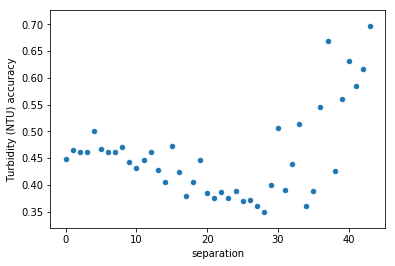

In [67]:
# Plot the accuracies vs window size for each column
seps = [x.days for x in separations]
for col in x_columns:
    df = pd.DataFrame({col + " accuracy": accuracies[col], 
                           "separation": seps})
    df.plot(kind="scatter", y=col + " accuracy", x="separation")

## Greedy Custom Separation Size
Create a greedy model using the best custom separation sizes found above.

In [70]:
# add the weather columns to our x_columns
x_columns = list(set(x_columns + 
                     ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 
                      'rainy', 'Wind Speed', 'Wind Angle']))

max_iter = 25000
loss = "log"

parameters = dict()
for col, sep in best_sep.items():
    print(col, sep)
    parameters[col] = {'separation':sep, 'x_win_size':pd.Timedelta('7 days')}

# Windowize
print("Windowizing 2017 data set:", train_index)
train = hf.windowize(train_dfs[train_index], 'datetime', 
                     target_column, custom_parameters=parameters)
print("Windowizing 2018 data set:", test_index)
test = hf.windowize(test_dfs[test_index], 'datetime', 
                    target_column, custom_parameters=parameters)
print()

#Add rainy column
for df in [test, train]:
    df['rainy'] = df['PRCP'].apply(
        lambda x: 1 if x > 0 else 0).astype('category')

#Add target columns
lrf.add_target_column([train, test], threshold=RFU_THRESHOLD)

# Sort columns by accuracy
model = SGDClassifier(max_iter=max_iter, loss=loss)
sorted_columns = lrf.sort_columns_by_metric(model, train, 
                                            test,
                                            x_columns,
                                            'bloom')
# Create greedy model
model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, predictions, _, _ = lrf.greedy_model(
    model, train, test, x_columns,'bloom', sorted_columns)
print("accuracy", accuracy)
print("recall", recall)
print("precision", precision)
print()

TMAX 16 days 00:00:00
TMIN 15 days 00:00:00
Wind Speed 8 days 00:00:00
ODO (mg/L) 4 days 00:00:00
ODOSat% 5 days 00:00:00
Wind Angle 0 days 00:00:00
rainy 8 days 00:00:00
pH 17 days 00:00:00
Sp Cond (uS/cm) 0 days 00:00:00
SNWD 8 days 00:00:00
pH (mV) 21 days 00:00:00
Temp C 23 days 00:00:00
SNOW 8 days 00:00:00
PRCP 9 days 00:00:00
Turbidity (NTU) 4 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model with: TMAX
Accuracy 0.8169491525423729
Recall: 0.842391304347826
Precision 0.8611111111111112
Confusion Matrix:
 [[ 86  25]
 [ 29 155]]

Training model with: TMIN
Accuracy 0.8305084745762712
Recall: 0.842391304347826
Precision 0.8806818181818182
Confusion Matrix:
 [[ 90  21]
 [ 29 155]]

Training model with: Wind Speed
Accuracy 0.5457627118644067
Recall: 0.5163

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.376271186440678
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[111   0]
 [184   0]]

Training model with: pH (mV)
Accuracy 0.6237288135593221
Recall: 1.0
Precision 0.6237288135593221
Confusion Matrix:
 [[  0 111]
 [  0 184]]

Training model with: Temp C
Accuracy 0.823728813559322
Recall: 0.7880434782608695
Precision 0.9177215189873418
Confusion Matrix:
 [[ 98  13]
 [ 39 145]]

Training model with: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.376271186440678
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[111   0]
 [184   0]]

Training model with: PRCP
Accuracy 0.6305084745762712
Recall: 0.7608695652173914
Precision 0.6829268292682927
Confusion Matrix:
 [[ 46  65]
 [ 44 140]]

Training model with: Turbidity (NTU)
Accuracy 0.5084745762711864
Recall: 0.6467391304347826
Precision 0.5979899497487438
Confusion Matrix:
 [[ 31  80]
 [ 65 119]]

ODOSat% metric value: 0.8779661016949153
ODO (mg/L) metric value: 0.8745762711864407
TMIN metric value: 0.8305084745762712
Temp C metric value: 0.823728813559322
TMAX metric value: 0.8169491525423729
pH metric value: 0.7491525423728813
PRCP metric value: 0.6305084745762712
pH (mV) metric value: 0.6237288135593221
rainy metric value: 0.5627118644067797
Wind Speed metric value: 0.5457627118644067
Turbidity (NTU) metric value: 0.5084745762711864
Wind Angle metric value: 0.47796610169491527
SNWD metric value: 0.376271186440678
SNOW metric value: 0.376271186440678
Sp Cond (uS/cm) metri

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'TMAX', 'pH', 'PRCP', 'pH (mV)', 'rainy', 'Wind Speed', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'TMAX', 'pH', 'PRCP', 'pH (mV)', 'rainy', 'Wind Speed', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8779661016949153
Test model recall: 0.8586956521739131
Test model precision: 0.9404761904761905

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.8745762711864407
Test model recall: 0.8586956521739131
Test model precision: 0.9349112426035503

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.864406779661017
Test model recall: 0.8532608695652174
Test model precision: 0.9235294117647059

Training model with: ['ODOSat%', 'Temp C']
Test model accuracy: 0.8779661016949153
Test model recall: 0

## Greedy Window Size
Find a single optimal window size for all features

In [ ]:
# add the weather columns to our x_columns
x_columns = list(set(x_columns + 
                     ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 
                      'rainy', 'Wind Speed', 'Wind Angle']))

iteration_delta = pd.Timedelta(1, unit='d')
max_x_window = pd.Timedelta(30, unit='d') 
current_y_window = pd.Timedelta(1, unit='d')
best_accuracy = 0
best_recall = 0
best_precision = 0
best_x_window = iteration_delta
best_y_window = current_y_window

window_sizes = []
accuracies = []

max_iter = 25000
loss = "log"

current_x_window = current_y_window
while current_x_window <= max_x_window:

    # Windowize
    print("current x window", current_x_window)
    print("Windowizing 2017 data set:", train_index)
    train = hf.data_window_reduction(
        train_dfs[train_index], 'datetime', target_column, 
        x_win_size=current_x_window, y_win_size=current_y_window)
    print("Windowizing 2018 data set:", test_index)
    test = hf.data_window_reduction(
        test_dfs[test_index], 'datetime', target_column,
        x_win_size=current_x_window, y_win_size=current_y_window)
    print()

    #Add rainy column
    for df in [test, train]:
        df['rainy'] = df['PRCP'].apply(
            lambda x: 1 if x > 0 else 0).astype('category')

    #Add target columns
    lrf.add_target_column([train, test], threshold=RFU_THRESHOLD)

    # Sort columns by accuracy
    model = SGDClassifier(max_iter=max_iter, loss=loss)
    sorted_columns = lrf.sort_columns_by_metric(model, train, 
                                                test,
                                                x_columns,
                                                'bloom', verbose=0)
    # Create greedy model
    model = SGDClassifier(max_iter=max_iter, loss=loss)
    accuracy, recall, precision, cm, predictions, _, _ = lrf.greedy_model(
        model, train, test, x_columns,'bloom', sorted_columns )
    accuracies.append(accuracy)
    window_sizes.append(current_x_window)
    print("accuracy", accuracy)
    print("recall", recall)
    print("precision", precision)
    print()
    if accuracy > best_accuracy:
        print("Better Accuracy Found")
        best_accuracy = accuracy
        best_recall = recall
        best_precision = precision
        best_x_window = current_x_window
        best_y_window = current_y_window
    current_x_window += iteration_delta

current x window 1 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...



C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'pH', 'TMIN', 'Temp C', 'TMAX', 'pH (mV)', 'Wind Angle', 'Wind Speed', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)', 'SNWD', 'Turbidity (NTU)', 'rainy']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'pH', 'TMIN', 'Temp C', 'TMAX', 'pH (mV)', 'Wind Angle', 'Wind Speed', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)', 'SNWD', 'Turbidity (NTU)', 'rainy']
Training model with: ['ODOSat%']
Test model accuracy: 0.7101449275362319
Test model recall: 0.6683417085427136
Test model precision: 0.7964071856287425

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.7072463768115942
Test model recall: 0.6984924623115578
Test model precision: 0.7722222222222223

Training model with: ['ODOSat%', 'pH']
Test model accuracy: 0.6811594202898551
Test model recall: 0.8793969849246231
Test model precision: 0.6704980842911877

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.7101449275362319
Test model recall: 0.67

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'pH', 'TMIN', 'Temp C', 'TMAX', 'pH (mV)', 'Wind Speed', 'Wind Angle', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)', 'SNWD', 'Turbidity (NTU)', 'rainy']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'pH', 'TMIN', 'Temp C', 'TMAX', 'pH (mV)', 'Wind Speed', 'Wind Angle', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)', 'SNWD', 'Turbidity (NTU)', 'rainy']
Training model with: ['ODOSat%']
Test model accuracy: 0.7288629737609329
Test model recall: 0.7085427135678392
Test model precision: 0.8011363636363636

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.7521865889212828
Test model recall: 0.7889447236180904
Test model precision: 0.785

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'pH']
Test model accuracy: 0.7551020408163265
Test model recall: 0.8944723618090452
Test model precision: 0.7385892116182573

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'pH', 'TMI

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'pH', 'TMIN', 'pH (mV)', 'Temp C', 'TMAX', 'Wind Speed', 'Wind Angle', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)', 'SNWD', 'Turbidity (NTU)', 'rainy']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'pH', 'TMIN', 'pH (mV)', 'Temp C', 'TMAX', 'Wind Speed', 'Wind Angle', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)', 'SNWD', 'Turbidity (NTU)', 'rainy']
Training model with: ['ODOSat%']
Test model accuracy: 0.7485380116959064
Test model recall: 0.7114427860696517
Test model precision: 0.8362573099415205

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.7543859649122807
Test model recall: 0.7611940298507462
Test model precision: 0.8095238095238095

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'pH']
Test model accuracy: 0.7748538011695907
Test model recall: 0.8706467661691543
Test model precision: 0.7743362831858407

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['ODO (mg/L)', 'ODOSat%', 'TMIN', 'pH', 'Temp C', 'TMAX', 'pH (mV)', 'Wind Speed', 'Wind Angle', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)', 'SNWD', 'Turbidity (NTU)', 'rainy']
adjusted sorted_columns: ['ODO (mg/L)', 'ODOSat%', 'TMIN', 'pH', 'Temp C', 'TMAX', 'pH (mV)', 'Wind Speed', 'Wind Angle', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)', 'SNWD', 'Turbidity (NTU)', 'rainy']
Training model with: ['ODO (mg/L)']
Test model accuracy: 0.7676470588235295
Test model recall: 0.7839195979899497
Test model precision: 0.8125

Updating greedy model

Training model with: ['ODO (mg/L)', 'ODOSat%']
Test model accuracy: 0.788235294117647
Test model recall: 0.7738693467336684
Test model precision: 0.850828729281768

Updating greedy model

Training model with: ['ODO (mg/L)', 'ODOSat%', 'TMIN']
Test model accuracy: 0.7911764705882353
Test model recall: 0.7939698492462312
Test model precision: 0.8404255319148937

Updating greedy model

Training model with: ['ODO (mg/L)', 'ODOSat%', 'TMIN'

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['ODO (mg/L)', 'ODOSat%', 'TMIN', 'pH', 'Temp C', 'TMAX', 'Wind Speed', 'pH (mV)', 'Wind Angle', 'Turbidity (NTU)', 'PRCP', 'SNOW', 'SNWD', 'rainy', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODO (mg/L)', 'ODOSat%', 'TMIN', 'pH', 'Temp C', 'TMAX', 'Wind Speed', 'pH (mV)', 'Wind Angle', 'Turbidity (NTU)', 'PRCP', 'SNOW', 'SNWD', 'rainy', 'Sp Cond (uS/cm)']
Training model with: ['ODO (mg/L)']
Test model accuracy: 0.7869822485207101
Test model recall: 0.817258883248731
Test model precision: 0.817258883248731

Updating greedy model

Training model with: ['ODO (mg/L)', 'ODOSat%']
Test model accuracy: 0.7988165680473372
Test model recall: 0.8071065989847716
Test model precision: 0.8412698412698413

Updating greedy model

Training model with: ['ODO (mg/L)', 'ODOSat%', 'TMIN']
Test model accuracy: 0.7958579881656804
Test model recall: 0.7969543147208121
Test model precision: 0.8440860215053764

Training model with: ['ODO (mg/L)', 'ODOSat%', 'pH']
Test model 

In [ ]:
print("best accuracy", best_accuracy)
print("best recall", best_recall)
print("best precision", best_precision)
print("best x window", best_x_window)

In [ ]:
# Plot Accuracy vs window size
df = pd.DataFrame({"accuracy": accuracies, 
                   "window size in days":[x.days for x in window_sizes]})
df.plot(kind="scatter", y="accuracy", x="window size in days")

## Find optimal Shift size using the best window size

In [44]:
# add the weather columns to our x_columns
x_columns = list(set(x_columns + 
                     ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 
                      'rainy', 'Wind Speed', 'Wind Angle']))

iteration_delta = pd.Timedelta('1 hour')
max_shift = pd.Timedelta('7 days')
shift = iteration_delta
best_accuracy = 0
best_recall = 0
best_precision = 0
best_shift = 0

shift_sizes = []
accuracies = []

max_iter = 25000
loss = "log"

while shift <= max_shift:

    # Windowize
    print("current shift size", shift)
    print("Windowizing 2017 data set:", train_index)
    train = hf.windowize(
        train_dfs[train_index], 'datetime', target_column, 
        x_win_size=best_x_window, y_win_size=best_y_window, shift=shift)
    print("Windowizing 2018 data set:", test_index)
    test = hf.windowize(
        test_dfs[test_index], 'datetime', target_column,
        x_win_size=best_x_window, y_win_size=best_y_window, shift=shift)
    print()

    #Add rainy column
    for df in [test, train]:
        df['rainy'] = df['PRCP'].apply(
            lambda x: 1 if x > 0 else 0).astype('category')

    #Add target columns
    lrf.add_target_column([train, test], threshold=RFU_THRESHOLD)

    # Sort columns by accuracy
    model = SGDClassifier(max_iter=max_iter, loss=loss)
    sorted_columns = lrf.sort_columns_by_metric(model, train, 
                                                test,
                                                x_columns,
                                                'bloom', verbose=0)
    # Create greedy model
    model = SGDClassifier(max_iter=max_iter, loss=loss)
    accuracy, recall, precision, cm, predictions, _, _ = lrf.greedy_model(
        model, train, test, x_columns,'bloom', sorted_columns )
    print("accuracy", accuracy)
    print("recall", recall)
    print("precision", precision)
    print()
    shift_sizes.append(shift)
    accuracies.append(accuracy)
    if accuracy > best_accuracy:
        print("Better Accuracy Found")
        best_shift = shift
        best_accuracy = accuracy
        best_recall = recall
        best_precision = precision
    # Once we hit 24 hours, start increasing shift by 1 day
    if shift >= pd.Timedelta('1 day'):
        iteration_delta = pd.Timedelta('1 day')
    shift += iteration_delta

current shift size 0 days 01:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...



C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.840925700365408
Test model recall: 0.8189220628150445
Test model precision: 0.9190600522193212

Updating greedy model

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.8579780755176614
Test model recall: 0.847227607599845
Test model precision: 0.9203875315922494

Updating greedy model

Training model with: ['ODOSat%', 'TMIN', 'ODO (mg/L)']
Test model accuracy: 0.8567600487210718
Test model recall: 0.8553702985653354
Test model precision: 0.9111937216026436

Training model with: ['ODOSat%', 'TMIN', 'Temp C']
Test model accuracy: 0

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8416950803701899
Test model recall: 0.8188854489164087
Test model precision: 0.9208006962576153

Updating greedy model

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.8582562104237701
Test model recall: 0.846749226006192
Test model precision: 0.9216512215669755

Updating greedy model

Training model with: ['ODOSat%', 'TMIN', 'ODO (mg/L)']
Test model accuracy: 0.8567949342425718
Test model recall: 0.8544891640866873
Test model precision: 0.912396694214876

Training model with: ['ODOSat%', 'TMIN', 'Temp C']
Test model accuracy: 0

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8378378378378378
Test model recall: 0.8160651920838184
Test model precision: 0.9163398692810457

Updating greedy model

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.8575602629656683
Test model recall: 0.8451688009313155
Test model precision: 0.9213197969543148

Updating greedy model

Training model with: ['ODOSat%', 'TMIN', 'ODO (mg/L)']
Test model accuracy: 0.8371073776479182
Test model recall: 0.8265424912689173
Test model precision: 0.9056122448979592

Training model with: ['ODOSat%', 'TMIN', 'Temp C']
Test model accuracy:

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'Wind Angle', 'PRCP', 'rainy', 'Turbidity (NTU)', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'Wind Angle', 'PRCP', 'rainy', 'Turbidity (NTU)', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8412852969814996
Test model recall: 0.8198757763975155
Test model precision: 0.9182608695652174

Updating greedy model

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.857838364167478
Test model recall: 0.8478260869565217
Test model precision: 0.9191919191919192

Updating greedy model

Training model with: ['ODOSat%', 'TMIN', 'ODO (mg/L)']
Test model accuracy: 0.8568646543330087
Test model recall: 0.8555900621118012
Test model precision: 0.9107438016528926

Training model with: ['ODOSat%', 'TMIN', 'Temp C']
Test model accuracy: 

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8416565164433617
Test model recall: 0.8210116731517509
Test model precision: 0.9173913043478261

Updating greedy model

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.8611449451887941
Test model recall: 0.8501945525291829
Test model precision: 0.9219409282700421

Updating greedy model

Training model with: ['ODOSat%', 'TMIN', 'ODO (mg/L)']
Test model accuracy: 0.8404384896467723
Test model recall: 0.830739299610895
Test model precision: 0.9065817409766455

Training model with: ['ODOSat%', 'TMIN', 'Temp C']
Test model accuracy: 

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'Wind Angle', 'PRCP', 'rainy', 'Turbidity (NTU)', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'Wind Angle', 'PRCP', 'rainy', 'Turbidity (NTU)', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8394160583941606
Test model recall: 0.8181818181818182
Test model precision: 0.9164490861618799

Updating greedy model

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.8569343065693431
Test model recall: 0.8461538461538461
Test model precision: 0.9189873417721519

Updating greedy model

Training model with: ['ODOSat%', 'TMIN', 'ODO (mg/L)']
Test model accuracy: 0.8291970802919708
Test model recall: 0.8251748251748252
Test model precision: 0.8939393939393939

Training model with: ['ODOSat%', 'TMIN', 'Temp C']
Test model accuracy:

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'pH', 'Wind Speed', 'TMAX', 'pH (mV)', 'PRCP', 'Turbidity (NTU)', 'rainy', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'pH', 'Wind Speed', 'TMAX', 'pH (mV)', 'PRCP', 'Turbidity (NTU)', 'rainy', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8432708688245315
Test model recall: 0.8184281842818428
Test model precision: 0.9235474006116208

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.8620102214650767
Test model recall: 0.8455284552845529
Test model precision: 0.9285714285714286

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'TMIN']
Test model accuracy: 0.858603066439523
Test model recall: 0.8509485094850948
Test model precision: 0.9181286549707602

Training model with: ['ODOSat%', 'ODO (mg/L)', 'Temp C']
Test mode

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'Wind Angle', 'PRCP', 'rainy', 'Turbidity (NTU)', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'Wind Angle', 'PRCP', 'rainy', 'Turbidity (NTU)', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8443579766536965
Test model recall: 0.822429906542056
Test model precision: 0.9198606271777003

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.8638132295719845
Test model recall: 0.8504672897196262
Test model precision: 0.9254237288135593

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'TMIN']
Test model accuracy: 0.8599221789883269
Test model recall: 0.8598130841121495
Test model precision: 0.9108910891089109

Training model with: ['ODOSat%', 'ODO (mg/L)', 'Temp C']
Test mode

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'Wind Angle', 'PRCP', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'Wind Angle', 'PRCP', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.838074398249453
Test model recall: 0.8153310104529616
Test model precision: 0.9176470588235294

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.8577680525164114
Test model recall: 0.8432055749128919
Test model precision: 0.9236641221374046

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'TMIN']
Test model accuracy: 0.8512035010940919
Test model recall: 0.8501742160278746
Test model precision: 0.9070631970260223

Training model with: ['ODOSat%', 'ODO (mg/L)', 'Temp C']
Test mode

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'PRCP', 'Wind Angle', 'rainy', 'Turbidity (NTU)', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'PRCP', 'Wind Angle', 'rainy', 'Turbidity (NTU)', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8442822384428224
Test model recall: 0.8217054263565892
Test model precision: 0.9217391304347826

Updating greedy model

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.8613138686131386
Test model recall: 0.8488372093023255
Test model precision: 0.9240506329113924

Updating greedy model

Training model with: ['ODOSat%', 'TMIN', 'ODO (mg/L)']
Test model accuracy: 0.829683698296837
Test model recall: 0.8217054263565892
Test model precision: 0.8983050847457628

Training model with: ['ODOSat%', 'TMIN', 'Temp C']
Test model accuracy: 

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'pH', 'Wind Speed', 'TMAX', 'pH (mV)', 'PRCP', 'Turbidity (NTU)', 'rainy', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'pH', 'Wind Speed', 'TMAX', 'pH (mV)', 'PRCP', 'Turbidity (NTU)', 'rainy', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.839572192513369
Test model recall: 0.8135593220338984
Test model precision: 0.9230769230769231

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.8556149732620321
Test model recall: 0.8389830508474576
Test model precision: 0.9252336448598131

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'TMIN']
Test model accuracy: 0.839572192513369
Test model recall: 0.826271186440678
Test model precision: 0.9112149532710281

Training model with: ['ODOSat%', 'ODO (mg/L)', 'Temp C']
Test model 

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'PRCP', 'Turbidity (NTU)', 'rainy', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'PRCP', 'Turbidity (NTU)', 'rainy', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8338192419825073
Test model recall: 0.8130841121495327
Test model precision: 0.9109947643979057

Updating greedy model

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.8571428571428571
Test model recall: 0.8457943925233645
Test model precision: 0.9187817258883249

Updating greedy model

Training model with: ['ODOSat%', 'TMIN', 'ODO (mg/L)']
Test model accuracy: 0.8367346938775511
Test model recall: 0.8271028037383178
Test model precision: 0.9030612244897959

Training model with: ['ODOSat%', 'TMIN', 'Temp C']
Test model accuracy:

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8322784810126582
Test model recall: 0.81
Test model precision: 0.9152542372881356

Updating greedy model

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.8512658227848101
Test model recall: 0.84
Test model precision: 0.9180327868852459

Updating greedy model

Training model with: ['ODOSat%', 'TMIN', 'ODO (mg/L)']
Test model accuracy: 0.8544303797468354
Test model recall: 0.84
Test model precision: 0.9230769230769231

Updating greedy model

Training model with: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C']
Test model accuracy: 0.71

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'pH', 'Wind Speed', 'Temp C', 'TMAX', 'pH (mV)', 'PRCP', 'Turbidity (NTU)', 'rainy', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'pH', 'Wind Speed', 'Temp C', 'TMAX', 'pH (mV)', 'PRCP', 'Turbidity (NTU)', 'rainy', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8435374149659864
Test model recall: 0.8085106382978723
Test model precision: 0.9382716049382716

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.8571428571428571
Test model recall: 0.8297872340425532
Test model precision: 0.9397590361445783

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'TMIN']
Test model accuracy: 0.8435374149659864
Test model recall: 0.8191489361702128
Test model precision: 0.927710843373494

Training model with: ['ODOSat%', 'ODO (mg/L)', 'pH']
Test model ac

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'pH', 'Wind Speed', 'TMAX', 'pH (mV)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'pH', 'Wind Speed', 'TMAX', 'pH (mV)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8394160583941606
Test model recall: 0.8187134502923976
Test model precision: 0.9150326797385621

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.8613138686131386
Test model recall: 0.847953216374269
Test model precision: 0.9235668789808917

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'TMIN']
Test model accuracy: 0.8248175182481752
Test model recall: 0.8187134502923976
Test model precision: 0.89171974522293

Training model with: ['ODOSat%', 'ODO (mg/L)', 'Temp C']
Test model 

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'Wind Speed', 'TMAX', 'pH', 'pH (mV)', 'PRCP', 'Wind Angle', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'Wind Speed', 'TMAX', 'pH', 'pH (mV)', 'PRCP', 'Wind Angle', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8521400778210116
Test model recall: 0.85625
Test model precision: 0.9013157894736842

Updating greedy model

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.8560311284046692
Test model recall: 0.8625
Test model precision: 0.9019607843137255

Updating greedy model

Training model with: ['ODOSat%', 'TMIN', 'ODO (mg/L)']
Test model accuracy: 0.8443579766536965
Test model recall: 0.85625
Test model precision: 0.8896103896103896

Training model with: ['ODOSat%', 'TMIN', 'Temp C']
Test model accuracy: 0.8015564202334631
Test model rec

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'Wind Speed', 'pH', 'TMAX', 'pH (mV)', 'PRCP', 'Turbidity (NTU)', 'rainy', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'Wind Speed', 'pH', 'TMAX', 'pH (mV)', 'PRCP', 'Turbidity (NTU)', 'rainy', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8347107438016529
Test model recall: 0.8187919463087249
Test model precision: 0.9037037037037037

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.859504132231405
Test model recall: 0.8523489932885906
Test model precision: 0.9136690647482014

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'TMIN']
Test model accuracy: 0.8429752066115702
Test model recall: 0.8389261744966443
Test model precision: 0.8992805755395683

Training model with: ['ODOSat%', 'ODO (mg/L)', 'Temp C']
Test mode

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'Wind Speed', 'TMAX', 'pH', 'pH (mV)', 'PRCP', 'Wind Angle', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'Wind Speed', 'TMAX', 'pH', 'pH (mV)', 'PRCP', 'Wind Angle', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8558951965065502
Test model recall: 0.8493150684931506
Test model precision: 0.9185185185185185

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.8558951965065502
Test model recall: 0.8561643835616438
Test model precision: 0.9124087591240876

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.8427947598253275
Test model recall: 0.863013698630137
Test model precision: 0.8873239436619719

Training model with: ['ODOSat%', 'Temp C']
Test model accuracy: 0.8602620087336245
Test model recall: 0

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'Wind Angle', 'PRCP', 'rainy', 'Turbidity (NTU)', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'Wind Angle', 'PRCP', 'rainy', 'Turbidity (NTU)', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8341013824884793
Test model recall: 0.8102189781021898
Test model precision: 0.9173553719008265

Updating greedy model

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.8525345622119815
Test model recall: 0.8394160583941606
Test model precision: 0.92

Updating greedy model

Training model with: ['ODOSat%', 'TMIN', 'ODO (mg/L)']
Test model accuracy: 0.8294930875576036
Test model recall: 0.8175182481751825
Test model precision: 0.9032258064516129

Training model with: ['ODOSat%', 'TMIN', 'Temp C']
Test model accuracy: 0.82027649769

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'TMAX', 'Wind Speed', 'pH', 'pH (mV)', 'PRCP', 'Wind Angle', 'rainy', 'Turbidity (NTU)', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'TMAX', 'Wind Speed', 'pH', 'pH (mV)', 'PRCP', 'Wind Angle', 'rainy', 'Turbidity (NTU)', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8446601941747572
Test model recall: 0.8217054263565892
Test model precision: 0.9217391304347826

Updating greedy model

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.8640776699029126
Test model recall: 0.8527131782945736
Test model precision: 0.9243697478991597

Updating greedy model

Training model with: ['ODOSat%', 'TMIN', 'ODO (mg/L)']
Test model accuracy: 0.8349514563106796
Test model recall: 0.8294573643410853
Test model precision: 0.8991596638655462

Training model with: ['ODOSat%', 'TMIN', 'Temp C']
Test model accuracy:

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'Wind Speed', 'pH', 'TMAX', 'pH (mV)', 'PRCP', 'Turbidity (NTU)', 'rainy', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'Wind Speed', 'pH', 'TMAX', 'pH (mV)', 'PRCP', 'Turbidity (NTU)', 'rainy', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8418367346938775
Test model recall: 0.819672131147541
Test model precision: 0.9174311926605505

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.8622448979591837
Test model recall: 0.8442622950819673
Test model precision: 0.9279279279279279

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'TMIN']
Test model accuracy: 0.8622448979591837
Test model recall: 0.8524590163934426
Test model precision: 0.9203539823008849

Training model with: ['ODOSat%', 'ODO (mg/L)', 'Temp C']
Test mode

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'Wind Angle', 'PRCP', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'Wind Angle', 'PRCP', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8502673796791443
Test model recall: 0.8220338983050848
Test model precision: 0.9326923076923077

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.8609625668449198
Test model recall: 0.847457627118644
Test model precision: 0.9259259259259259

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'TMIN']
Test model accuracy: 0.839572192513369
Test model recall: 0.8305084745762712
Test model precision: 0.9074074074074074

Training model with: ['ODOSat%', 'ODO (mg/L)', 'Temp C']
Test model

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'TMAX', 'Wind Speed', 'pH', 'pH (mV)', 'PRCP', 'Wind Angle', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'TMAX', 'Wind Speed', 'pH', 'pH (mV)', 'PRCP', 'Wind Angle', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8659217877094972
Test model recall: 0.8584070796460177
Test model precision: 0.9238095238095239

Updating greedy model

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.8659217877094972
Test model recall: 0.8584070796460177
Test model precision: 0.9238095238095239

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.8715083798882681
Test model recall: 0.8584070796460177
Test model precision: 0.9326923076923077

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'Temp C']
Test model accuracy: 0

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'TMAX', 'pH', 'Wind Speed', 'pH (mV)', 'PRCP', 'rainy', 'Wind Angle', 'Turbidity (NTU)', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'TMAX', 'pH', 'Wind Speed', 'pH (mV)', 'PRCP', 'rainy', 'Wind Angle', 'Turbidity (NTU)', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8488372093023255
Test model recall: 0.8365384615384616
Test model precision: 0.90625

Updating greedy model

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.872093023255814
Test model recall: 0.8653846153846154
Test model precision: 0.9183673469387755

Updating greedy model

Training model with: ['ODOSat%', 'TMIN', 'ODO (mg/L)']
Test model accuracy: 0.8488372093023255
Test model recall: 0.8461538461538461
Test model precision: 0.8979591836734694

Training model with: ['ODOSat%', 'TMIN', 'Temp C']
Test model accuracy: 0.813953488

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'TMAX', 'Wind Speed', 'PRCP', 'pH', 'pH (mV)', 'Wind Angle', 'rainy', 'SNWD', 'SNOW', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'TMAX', 'Wind Speed', 'PRCP', 'pH', 'pH (mV)', 'Wind Angle', 'rainy', 'SNWD', 'SNOW', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.872093023255814
Test model recall: 0.8979591836734694
Test model precision: 0.88

Updating greedy model

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.872093023255814
Test model recall: 0.8979591836734694
Test model precision: 0.88

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.8372093023255814
Test model recall: 0.8571428571428571
Test model precision: 0.8571428571428571

Training model with: ['ODOSat%', 'Temp C']
Test model accuracy: 0.8372093023255814
Test model recall: 0.8571428571428571
Test model 

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'TMAX', 'Temp C', 'Wind Speed', 'pH', 'pH (mV)', 'rainy', 'SNWD', 'SNOW', 'PRCP', 'Turbidity (NTU)', 'Wind Angle', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'TMAX', 'Temp C', 'Wind Speed', 'pH', 'pH (mV)', 'rainy', 'SNWD', 'SNOW', 'PRCP', 'Turbidity (NTU)', 'Wind Angle', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8620689655172413
Test model recall: 0.8529411764705882
Test model precision: 0.90625

Updating greedy model

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.8620689655172413
Test model recall: 0.8529411764705882
Test model precision: 0.90625

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.8620689655172413
Test model recall: 0.8529411764705882
Test model precision: 0.90625

Training model with: ['ODOSat%', 'TMAX']
Test model accuracy: 0.8275862068965517
Test model recall: 0.7941176470588235
Test model preci

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'TMAX', 'Wind Speed', 'Wind Angle', 'pH', 'pH (mV)', 'PRCP', 'rainy', 'SNWD', 'Temp C', 'SNOW', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'TMAX', 'Wind Speed', 'Wind Angle', 'pH', 'pH (mV)', 'PRCP', 'rainy', 'SNWD', 'Temp C', 'SNOW', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8837209302325582
Test model recall: 0.9166666666666666
Test model precision: 0.88

Updating greedy model

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.8604651162790697
Test model recall: 0.875
Test model precision: 0.875

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.7906976744186046
Test model recall: 0.875
Test model precision: 0.7777777777777778

Training model with: ['ODOSat%', 'TMAX']
Test model accuracy: 0.8372093023255814
Test model recall: 0.8333333333333334
Test model precision: 0.869565217391

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'TMAX', 'Wind Speed', 'Temp C', 'pH', 'pH (mV)', 'rainy', 'SNWD', 'SNOW', 'PRCP', 'Wind Angle', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'TMAX', 'Wind Speed', 'Temp C', 'pH', 'pH (mV)', 'rainy', 'SNWD', 'SNOW', 'PRCP', 'Wind Angle', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8275862068965517
Test model recall: 0.8235294117647058
Test model precision: 0.875

Updating greedy model

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.8275862068965517
Test model recall: 0.8235294117647058
Test model precision: 0.875

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.8275862068965517
Test model recall: 0.8235294117647058
Test model precision: 0.875

Training model with: ['ODOSat%', 'TMAX']
Test model accuracy: 0.7931034482758621
Test model recall: 0.7647058823529411
Test model precision: 

In [62]:
print("best accuracy", best_accuracy)
print("best recall", best_recall)
print("best precision", best_precision)
print("best shift", best_shift)

best accuracy 0.896551724137931
best recall 0.8823529411764706
best precision 0.9375
best shift 6 days 00:00:00


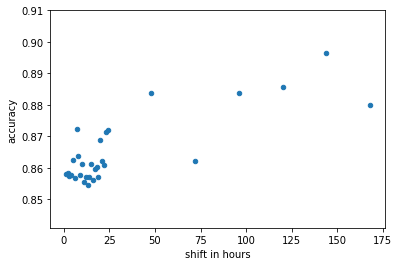

In [61]:
# Plot Accuracy vs shift size
df = pd.DataFrame({"accuracy": accuracies, 
                   "shift in hours": [(s.seconds / 60 / 60) + (s.days * 24) 
                             for s in shift_sizes]})
df.plot(kind="scatter", y="accuracy", x="shift in hours")

## Cross validate Best window models

In [71]:
print("best accuracy", best_accuracy)
print("best recall", best_recall)
print("best precision", best_precision)
print("best x window", best_x_window)

best accuracy 0
best recall 0
best precision 0
best x window 1 days 00:00:00


## Add Weather Category

In [ ]:
# Add a rainy category
for df in test_dfs + train_dfs:
    df['rainy'] = df['PRCP'].apply(
        lambda x: 1 if x > 0 else 0).astype('category')
test_dfs[test_index].columns

In [ ]:
# add the weather columns to our x_columns
x_columns = list(set(x_columns + 
                     ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 
                      'rainy', 'Wind Speed', 'Wind Angle']))

In [ ]:
lrf.add_target_column(train_dfs + test_dfs, threshold=RFU_THRESHOLD)

## Logistic Regression Model